In [1]:
#imports
from matplotlib import pyplot as plt
from scipy.stats import entropy
import numpy as np
import torch
import sys
import glob
sys.path.insert(0, '..')
from models import Classifier
from losses import WeightedMSE, FlatLoss, Disco
from utils import Metrics, find_threshold, DataSet, Logger, swish
from utils import LegendreFitter, LegendreIntegral
from torch.autograd import gradcheck
torch.manual_seed(72)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print('device used in training:', device)

device used in training: cuda:0


In [2]:
def metric_calc(model,X,y,x_biased,metric=None):
    predictions = np.array(model(X).tolist()).flatten()
    if metric is None:
        metrics_test = Metrics(validation=True) 
    else:
        metrics_test = metric(validation=True) 
    metrics_test.calculate(pred=predictions, target=y,m=x_biased)
    R50 = metrics_test.R50[0]
    JSD = metrics_test.JSD[0]
    return (1/JSD,R50)
class Metrics2():
    def __init__(self,validation=False):
        self.validation = validation
        self.losses = []
        self.accs = []
        self.signalE = []
        self.backgroundE= []
        if self.validation:
            self.R50 = []
            self.JSD = []
    def calculate(self,pred,target,l=None,m=None):
        preds = np.array(pred.tolist()).flatten()
        targets = np.array(target.tolist()).flatten()
        acc = (preds.round()==targets).sum()/targets.shape[0]
        signal_efficiency = ((preds.round()==targets)&(targets==1)).sum()/(targets==1).sum()
        background_efficiency = ((preds.round()==targets)&(targets==0)).sum()/(targets==0).sum()


        if self.validation:
            c = find_threshold(preds,(targets==0),0.5)
            R50 = 1/((preds[targets==1]<c).sum()/(targets==1).sum())
            self.R50.append(R50)
            if m is not None:
                m = np.array(m.tolist()).flatten()
                hist1, bins = np.histogram(m[targets==1],bins=50,density=True,range=[50,300])
                hist2, _ = np.histogram(m[(targets==1)&(preds<c)],bins=50,density=True,range=[50,300])
                JSD = 0.5*(entropy(hist1,0.5*(hist1+hist2),base=2)+entropy(hist2,0.5*(hist1+hist2),base=2))#*(bins[1]-bins[0])
                self.JSD.append(JSD)
        self.accs.append(acc)
        self.signalE.append(signal_efficiency)
        self.backgroundE.append(background_efficiency)
        if l:
            self.losses.append(l)
def plot_stuff(model,X,y,x_biased,mbins=100,histbins=None,name='Naive DNN',f=None,ptype=0,dynamicbins=True,scale=None):
    if histbins == None:
        histbins=mbins
    predictions = np.array(model(X).tolist()).flatten()
    metrics_test = Metrics(validation=True) 
    metrics_test.calculate(pred=predictions, target=y,m=x_biased)
    R50 = metrics_test.R50[0]
    JSD = metrics_test.JSD[0]
    
    
    c = find_threshold(predictions,(y==0),0.5)
    fig, [ax,ax1] = plt.subplots(2,1,figsize=(6,8),dpi=120,sharex=True)
    _,bins,_ = ax.hist(x_biased[(y==1)],bins=histbins,alpha=0.3,color='C1',label='Background',density=True,log=True)
    ax.hist(x_biased[(y==1)&(predictions<c)],bins=bins,alpha=0.3,color='C0',label='False Positives',density=True,log=True)
    ax.set_ylabel("Normed Counts",fontsize=14)
    ax.set_title('{} (R50:{:.2f}, 1/JSD:{:.2f})'.format(name,R50,1/JSD))
    ax.legend()

    efficiencies = np.linspace(0.1,0.9,9)
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(predictions,(y==0),eff))
    m = x_biased[y==1]
    scores = predictions[y==1]
    if dynamicbins:
        sorted_m = np.argsort(m)
        scores = scores[sorted_m].reshape(mbins,-1)
        m = m[sorted_m]
        m = m.reshape(mbins,-1).mean(axis=1)
    else:
        _,bins = np.histogram(m,bins=mbins)
        digitized = np.digitize(m,bins)
        m = bins[:-1]
    for j,cut in enumerate(cuts):
        c = f"C{j}" #if j!= 6 else f"C11"
        if dynamicbins:
            passed = (scores<cut).sum(axis=1)/scores.shape[1]
        else:
            passed = [(scores[digitized==i]<cut).sum()/(digitized==i).sum() for i in range(mbins)]
        if ptype == 0:
            ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)
        else:
            ax1.step(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)
    if scale is not None:
        ax1.set_yscale(scale)        
    ax1.set_ylabel("False Pos. Rate",fontsize=14)
    ax1.set_ylim([-0.02,1.02])
    ax1.legend(loc='upper right', bbox_to_anchor=(1,1) ,markerscale=5,title="SE (Cut)",ncol=3)
    ax1.set_xlabel(r"$m$",fontsize=14)
    fig.tight_layout(pad=0)
    if f is not None:
        fig.savefig(f)
    plt.show()
    return (1/JSD,R50)
class Model(Classifier):
    def __init__(self,input_size=10,name=None):
        """
         DNN Model inherits from torch.torch.nn.Module. Can be initialized with input_size: Number of features per sample.

        This is a class wrapper for a simple DNN model. Creates an instance of torch.torch.nn.Module that has 4 linear layers. Use torchsummary for details.abs

        Parameters
        ----------
        input_size : int=10
            The number of features to train on.
        name : string=None
            Specifiy a name for the Dtorch.nn.break
        """
        super(Classifier,self).__init__()
        self.linear = torch.nn.Linear(input_size,64)
        self.linear1 = torch.nn.Linear(64,64,)
        self.linear2 = torch.nn.Linear(64,64)
        self.linear3 = torch.nn.Linear(64,64)
        self.batchnorm = torch.nn.BatchNorm1d(64)
        self.out = torch.nn.Linear(64,1)
        # Defaults
        self.optimizer = torch.optim.SGD(self.parameters(),lr=1e-3)
        self.yhat_val = None
        self.yhat = None
        self.name = name
    def forward(self, x):
        x = torch.nn.functional.relu(self.linear(x))
#         x = torch.nn.functional.relu(self.linear1(x))
        x = torch.nn.functional.relu(self.linear1(x))
        x = self.batchnorm(x)
        x = torch.nn.functional.relu(self.linear2(x))
        x = torch.nn.functional.relu(self.linear3(x))
        x = torch.sigmoid(self.out(x))
        return x 
class Model2(Classifier):
    def __init__(self,input_size=10,name=None):
        """
         DNN Model inherits from torch.torch.nn.Module. Can be initialized with input_size: Number of features per sample.

        This is a class wrapper for a simple DNN model. Creates an instance of torch.torch.nn.Module that has 4 linear layers. Use torchsummary for details.abs

        Parameters
        ----------
        input_size : int=10
            The number of features to train on.
        name : string=None
            Specifiy a name for the Dtorch.nn.break
        """
        super(Classifier,self).__init__()
        self.linear = torch.nn.Linear(input_size,64)
        self.linear1 = torch.nn.Linear(64,64)
        self.linear2 = torch.nn.Linear(128,64)
        self.linear3 = torch.nn.Linear(128,32)
        self.batchnorm = torch.nn.BatchNorm1d(64)
        self.out = torch.nn.Linear(32,1)
        # Defaults
        self.optimizer = torch.optim.SGD(self.parameters(),lr=1e-3)
        self.yhat_val = None
        self.yhat = None
        self.name = name
    def forward(self, x):
        x = torch.nn.functional.relu(self.linear(x))
        x1 = torch.nn.functional.relu(self.linear1(x))
        x1 = self.batchnorm(x1)
        x2 = torch.nn.functional.relu(self.linear2(torch.cat([x,x1],dim=1)))
        x3 = torch.nn.functional.relu(self.linear3(torch.cat([x1,x2],dim=1)))
        x3 = torch.sigmoid(self.out(x3))
        return x3
class Model3(Classifier):
    def __init__(self,input_size=10,name=None):
        """
         DNN Model inherits from torch.torch.nn.Module. Can be initialized with input_size: Number of features per sample.

        This is a class wrapper for a simple DNN model. Creates an instance of torch.torch.nn.Module that has 4 linear layers. Use torchsummary for details.abs

        Parameters
        ----------
        input_size : int=10
            The number of features to train on.
        name : string=None
            Specifiy a name for the Dtorch.nn.break
        """
        super(Classifier,self).__init__()
        self.linear = torch.nn.Linear(input_size,64)
        self.linear1 = torch.nn.Linear(64,64,)
        self.linear2 = torch.nn.Linear(64,64)
        self.linear3 = torch.nn.Linear(64,64)
        self.batchnorm = torch.nn.BatchNorm1d(64)
        self.out = torch.nn.Linear(64,1)
        # Defaults
        self.optimizer = torch.optim.SGD(self.parameters(),lr=1e-3)
        self.yhat_val = None
        self.yhat = None
        self.name = name
    def forward(self, x):
        x = swish(self.linear(x))
        x = swish(self.linear1(x))
        x = self.batchnorm(x)
        x = swish(self.linear2(x))
        x = swish(self.linear3(x))
        x = torch.sigmoid(self.out(x))
        return x 
class ReduceLROnPlateau(torch.optim.lr_scheduler.ReduceLROnPlateau):
    def __repr__(self):
        keys = ['patience','factor', 'min_lr', 'cooldown', 
                'mode', 'threshold', 'threshold_mode', 'verbose']
        values = [self.patience, self.factor, self.min_lrs,  
                  self.cooldown, self.mode, self.threshold, 
                self.threshold_mode,self.verbose]
        string = self.__class__.__name__ +"(\n"
        for key,value in zip(keys,values):
            string += f"     {key}: {value}\n"
        string += ')'
        return string
class MultiStepLR(torch.optim.lr_scheduler.MultiStepLR):
    def __repr__(self):
        keys = ['milestones','gamma']
        values = [self.milestones, self.gamma]
        string = self.__class__.__name__ +"(\n"
        for key,value in zip(keys,values):
            string += f"     {key}: {value}\n"
        string += ')'
        return string

In [3]:
path = "./logs/architectures/ensemble/"

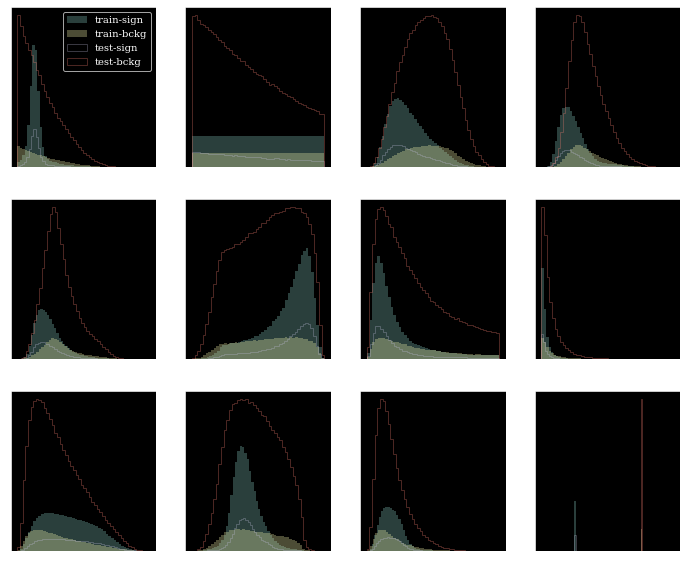

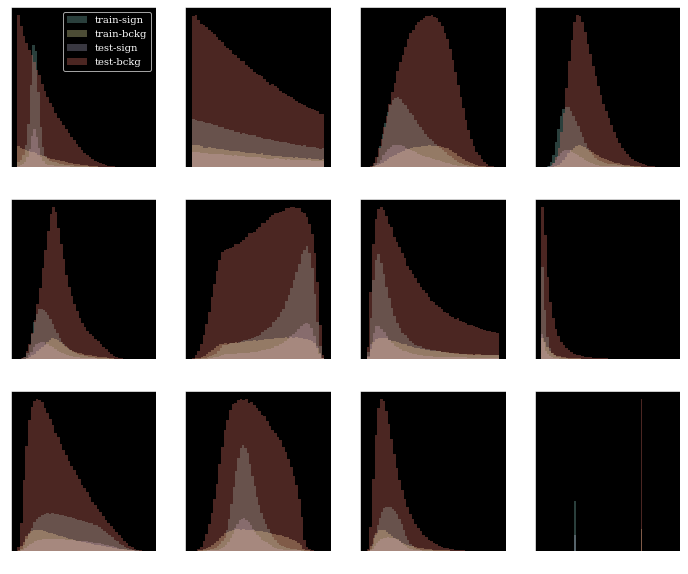

In [4]:
/#dataset 
files = np.load("data/W_FCN_v0.npz")
train = files["train"].astype('float32')
val = files["val"].astype('float32')
test = files["test"].astype('float32')

train_labels = train[::,-1]
val_labels   = val[::,-1]
test_labels=test[::,-1]

data = np.concatenate([train,val,test],axis=0)
maxdata = data.max(axis=0)
mindata = data.min(axis=0)
data = (data-mindata)/(maxdata-mindata)
data[::,0] = 2*(data[::,0]-data[:,0].min())/(data[:,0].max()-data[:,0].min())-1

train = data[:train.shape[0]]
val = data[train.shape[0]:val.shape[0]+train.shape[0]]
test = data[val.shape[0]+train.shape[0]:]

#weighting
weights, bins = np.histogram(train[:,1][train[:,-1]==0],bins=50)
weights = 1/weights
#weights *=  sum(train[:,-1]==0)/(len(bins)-1)
weights_pt0 = np.array([weights[index] for index in np.digitize(train[:,1][train[:,-1]==0],
                                                                bins[1:],right=True)])
weights_pt0 *=  sum(train[:,-1]==0)/weights_pt0.sum()


weights, bins = np.histogram(train[:,1][train[:,-1]==1],bins=50)
weights = 1/weights
#weights *= sum(train[:,-1]==1)/(len(bins)-1)
weights_pt1 = np.array([weights[index] for index in np.digitize(train[:,1][train[:,-1]==1],
                                                                bins[1:],right=True)])
weights_pt1 *=  sum(train[:,-1]==1)/weights_pt1.sum()

weights = np.ones_like(train[:,-1])
weights[train[:,-1]==0] = weights_pt0
weights[train[:,-1]==1] = weights_pt1

traindataset = DataSet(samples=train[::,1:-1],
                       labels=train_labels,
                       #weights=weights,
                       m = train[::,0])
valdataset = DataSet(samples=val[:,1:-1],
                     labels=val_labels,
                    m = val[::,0])
X = torch.from_numpy(test[:,1:11]).float()#.to(device)


fig, axes = plt.subplots(3,4,figsize=(12,10))
histtype='bar'
for i,ax in enumerate(axes.flatten()):
    if i==11:histtype='bar'
    ax.hist(train[:,i][train[:,-1]==0],bins=50,weights=weights_pt0,alpha=0.3,label='train-sign',histtype=histtype)
    ax.hist(train[:,i][train[:,-1]==1],bins=50,weights=weights_pt1,alpha=0.3,label='train-bckg',histtype=histtype)
    ax.hist(test[:,i][test[:,-1]==0],bins=50,alpha=0.3,label='test-sign',histtype='step')
    ax.hist(test[:,i][test[:,-1]==1],bins=50,alpha=0.3,label='test-bckg',histtype='step')
    ax.set_yticks([])
    if i==0: ax.legend()
fig.savefig(path+"data2.pdf")

fig, axes = plt.subplots(3,4,figsize=(12,10))
for i,ax in enumerate(axes.flatten()):
    ax.hist(train[:,i][train[:,-1]==0],bins=50,alpha=0.3,label='train-sign')
    ax.hist(train[:,i][train[:,-1]==1],bins=50,alpha=0.3,label='train-bckg')
    ax.hist(test[:,i][test[:,-1]==0],bins=50,alpha=0.3,label='test-sign')
    ax.hist(test[:,i][test[:,-1]==1],bins=50,alpha=0.3,label='test-bckg')
    ax.set_yticks([])
    if i==0: ax.legend()
fig.savefig(path+"data.pdf")

test_mass = files["test"].astype('float32')[:,0]*250+50

In [5]:
params = {'epochs'     : 200,
          'interval'   : 200,
          'batch_size' : 65536,
          'shuffle'    : True,
          'num_workers': 6,
          'drop_last'  :True,
          'device'     : device,
          'pass_x_biased':False,
         }

Entering Training...
Epoch:0001/0200  (9.5  s)
 Train: loss:0.3115, acc:67.5% || Val: loss: 0.0968, acc:80.5%, R50: 6.8571, 1/JSD: 25.6131
Epoch:0200/0200  (238.8s)
 Train: loss:0.1785, acc:81.8% || Val: loss: 0.0510, acc:83.0%, R50: 26.6774, 1/JSD: 3.2877


/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


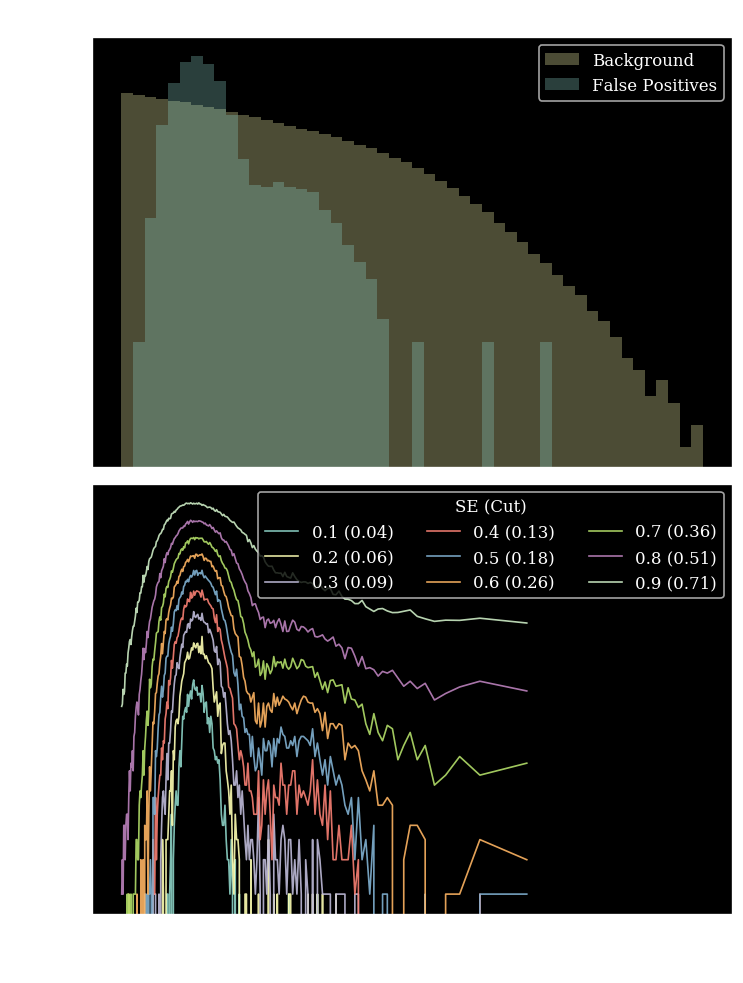

Entering Training...
Epoch:0001/0200  (8.9  s)
 Train: loss:0.3063, acc:69.3% || Val: loss: 0.0966, acc:80.5%, R50: 6.2394, 1/JSD: 30.1703
Epoch:0200/0200  (241.4s)
 Train: loss:0.1773, acc:81.8% || Val: loss: 0.0507, acc:81.4%, R50: 27.0825, 1/JSD: 2.9255


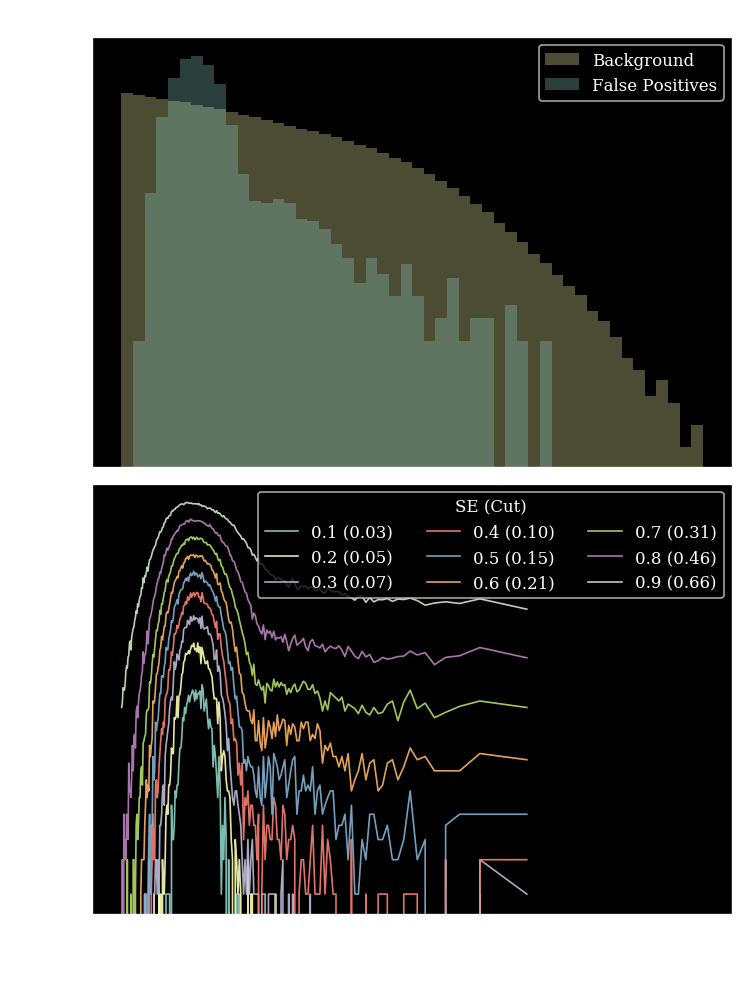

Entering Training...
Epoch:0001/0200  (9.3  s)
 Train: loss:0.3029, acc:69.0% || Val: loss: 0.0964, acc:78.0%, R50: 8.8054, 1/JSD: 58.0910
Epoch:0200/0200  (213.2s)
 Train: loss:0.1777, acc:81.9% || Val: loss: 0.0509, acc:81.7%, R50: 26.6430, 1/JSD: 3.0426


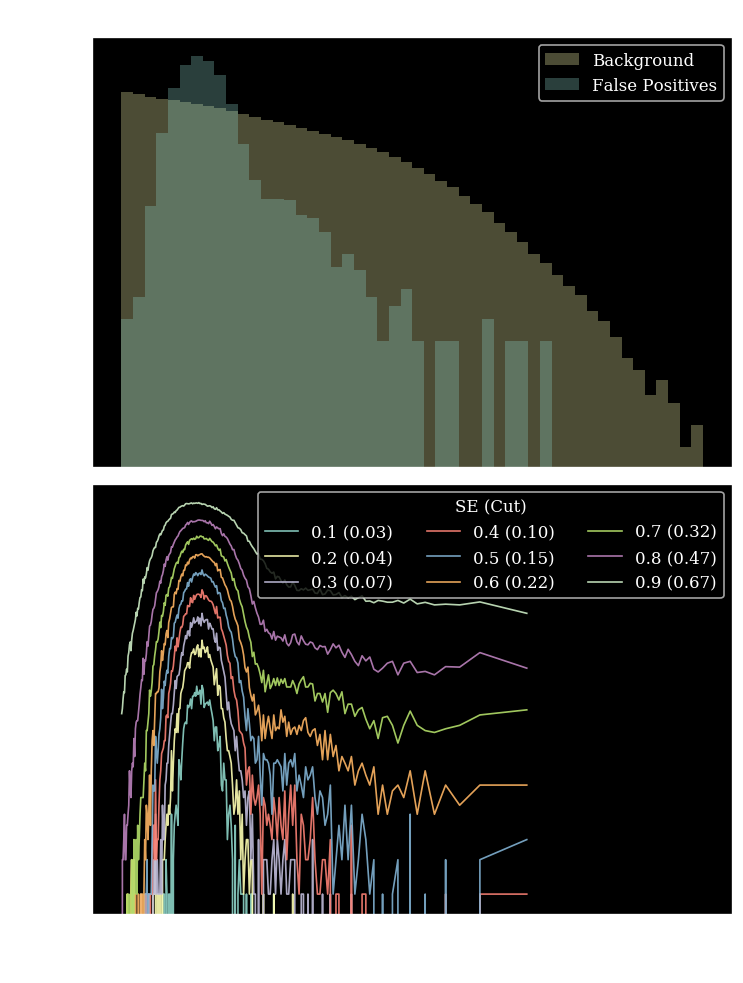

Entering Training...
Epoch:0001/0200  (9.0  s)
 Train: loss:0.3018, acc:67.3% || Val: loss: 0.0968, acc:64.0%, R50: 5.5706, 1/JSD: 18.1500
Epoch:0200/0200  (237.4s)
 Train: loss:0.1766, acc:81.8% || Val: loss: 0.0509, acc:81.1%, R50: 26.6861, 1/JSD: 2.7679


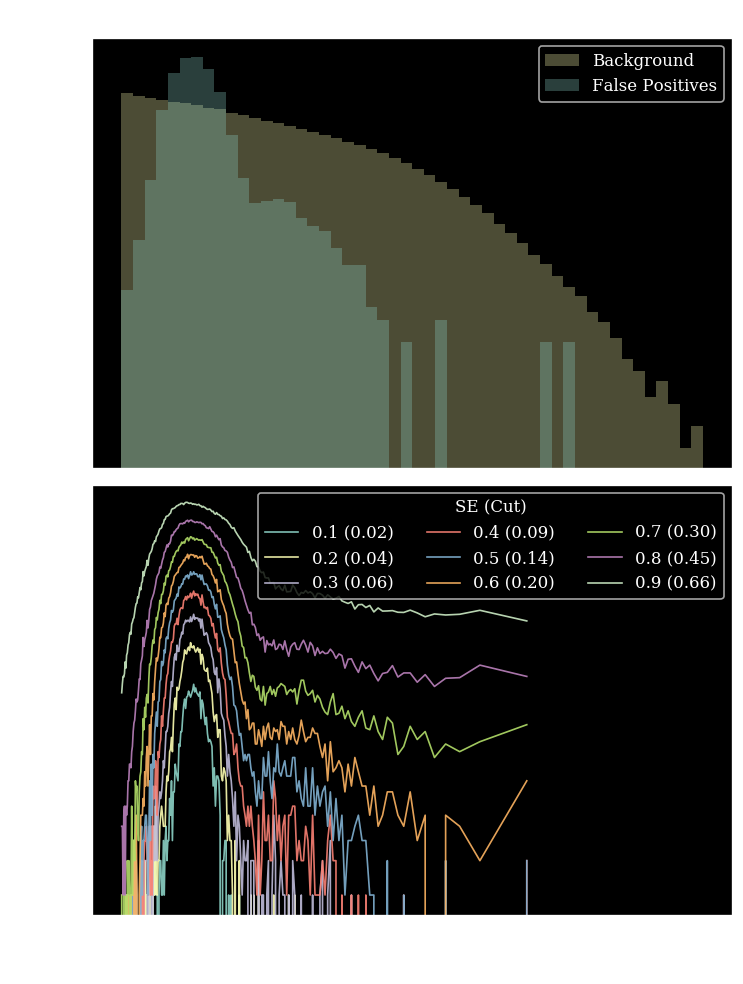

Entering Training...
Epoch:0001/0200  (9.0  s)
 Train: loss:0.3004, acc:73.0% || Val: loss: 0.0970, acc:19.5%, R50: 5.7532, 1/JSD: 20.5542
Epoch:0200/0200  (237.7s)
 Train: loss:0.1764, acc:81.5% || Val: loss: 0.0508, acc:81.7%, R50: 26.8927, 1/JSD: 3.3561


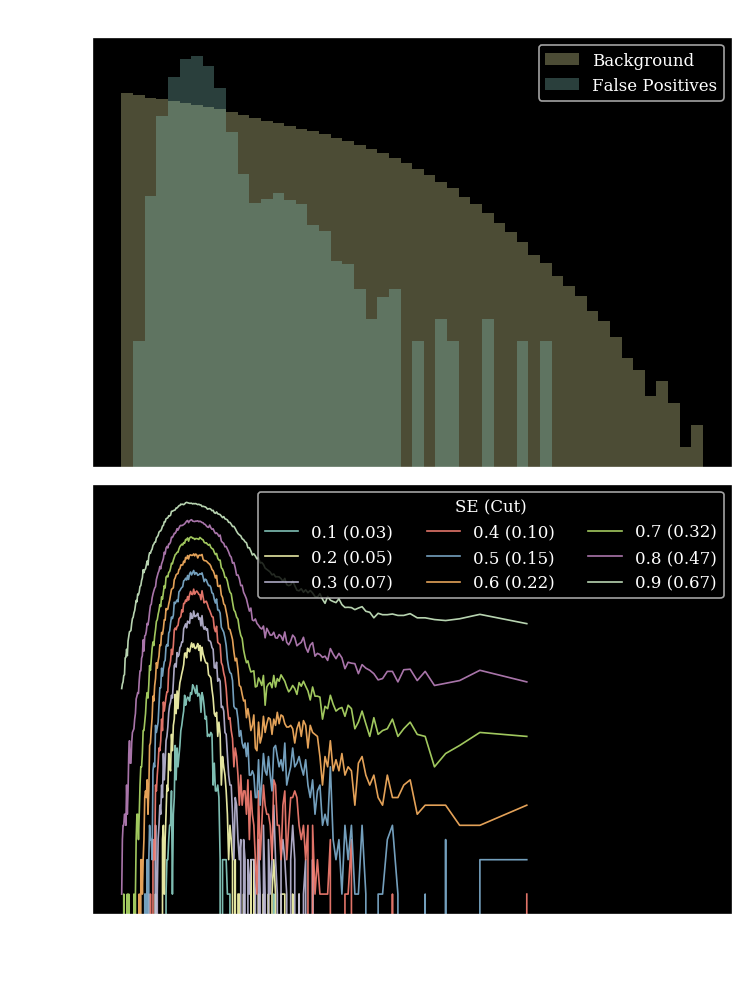

Entering Training...
Epoch:0001/0200  (9.1  s)
 Train: loss:0.3170, acc:61.1% || Val: loss: 0.0976, acc:80.5%, R50: 6.3546, 1/JSD: 130.5300
Epoch:0200/0200  (238.5s)
 Train: loss:0.1767, acc:81.9% || Val: loss: 0.0513, acc:83.3%, R50: 26.4275, 1/JSD: 3.7337


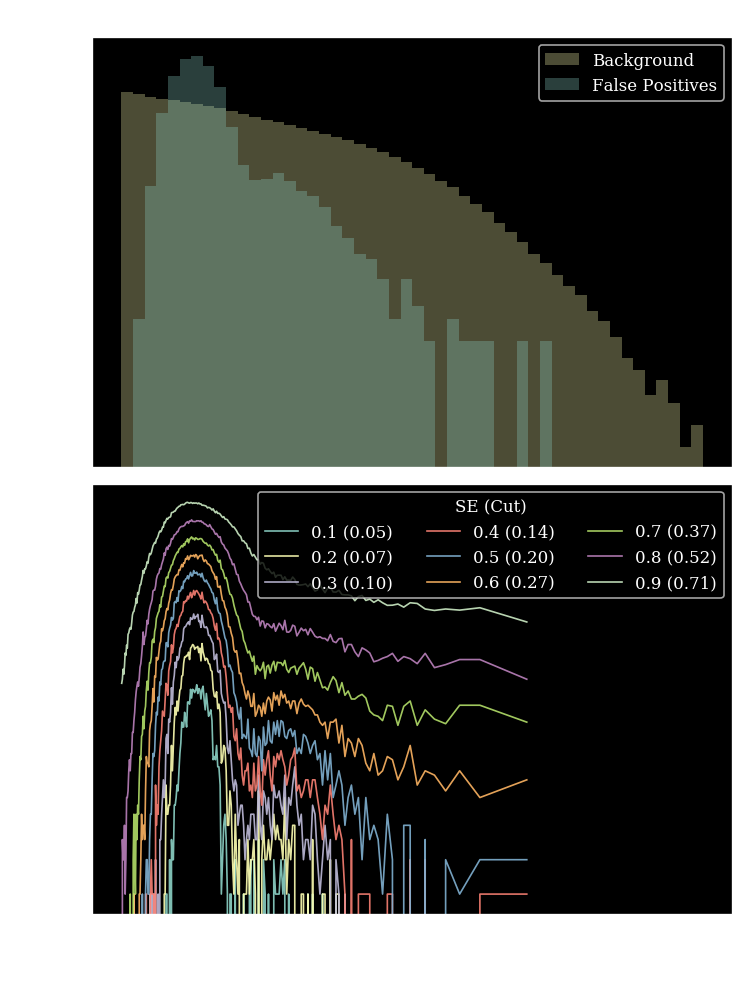

Entering Training...
Epoch:0001/0200  (9.2  s)
 Train: loss:0.3040, acc:70.1% || Val: loss: 0.0963, acc:44.1%, R50: 6.2568, 1/JSD: 19.0376
Epoch:0200/0200  (238.3s)
 Train: loss:0.1779, acc:81.5% || Val: loss: 0.0512, acc:80.3%, R50: 27.2435, 1/JSD: 2.8312


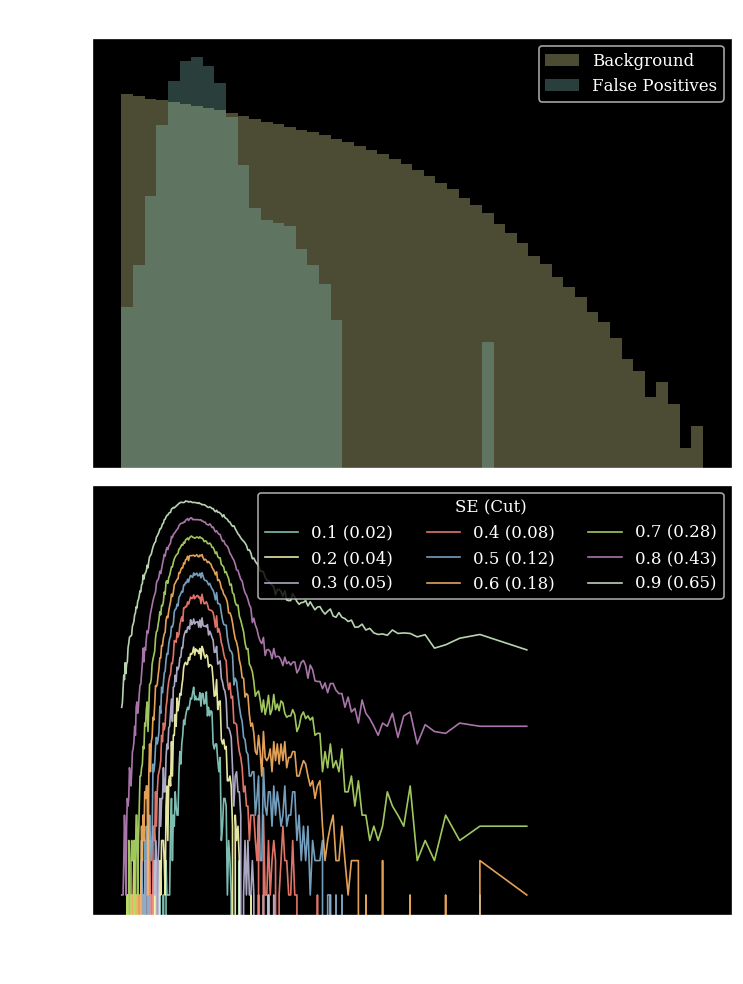

Entering Training...
Epoch:0001/0200  (9.1  s)
 Train: loss:0.2920, acc:69.9% || Val: loss: 0.0966, acc:82.8%, R50: 8.7235, 1/JSD: 42.9214
Epoch:0200/0200  (238.4s)
 Train: loss:0.1769, acc:81.9% || Val: loss: 0.0510, acc:81.8%, R50: 26.4529, 1/JSD: 2.6995


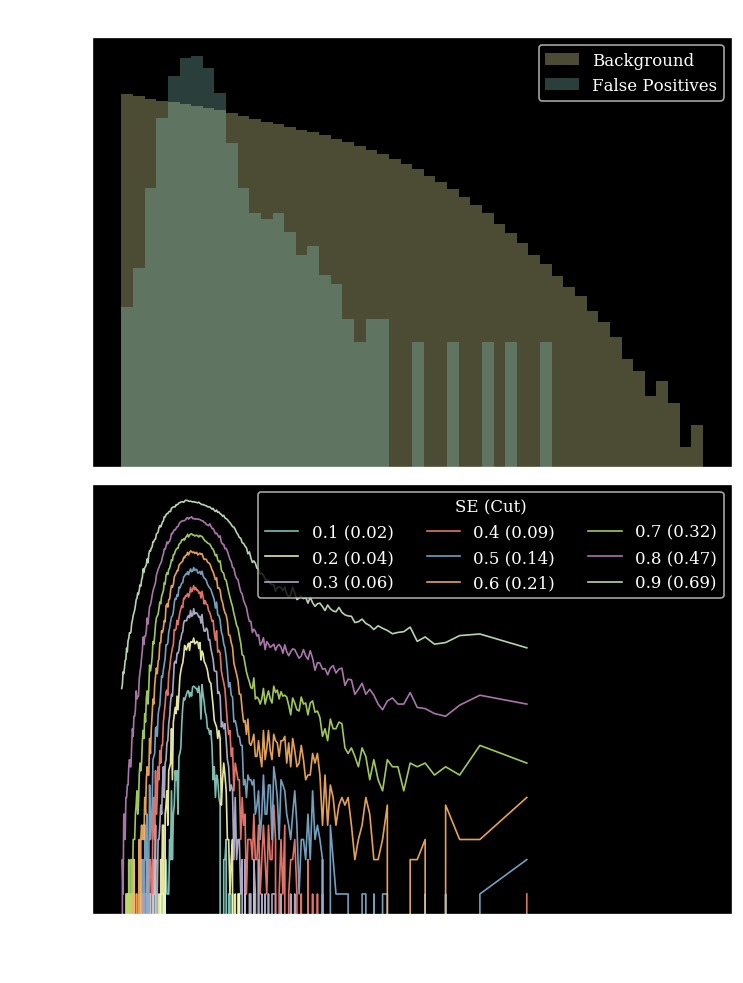

Entering Training...
Epoch:0001/0200  (9.2  s)
 Train: loss:0.3048, acc:64.4% || Val: loss: 0.0969, acc:80.5%, R50: 6.3157, 1/JSD: 51.3055
Epoch:0200/0200  (237.7s)
 Train: loss:0.1780, acc:81.9% || Val: loss: 0.0508, acc:82.5%, R50: 26.9872, 1/JSD: 3.3295


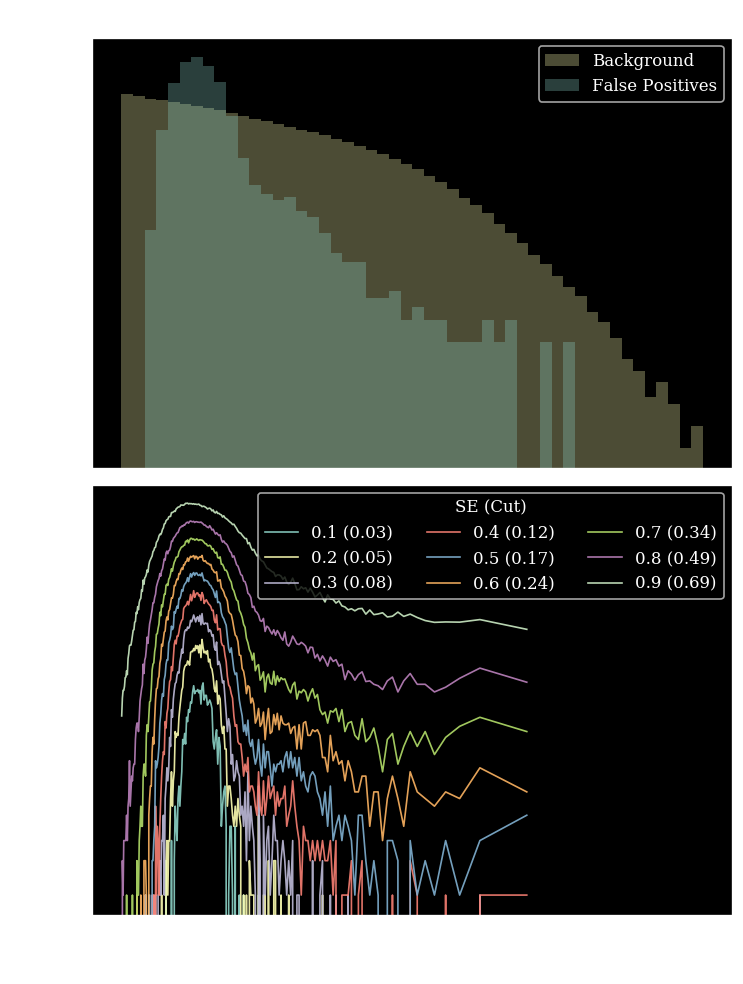

Entering Training...
Epoch:0001/0200  (9.2  s)
 Train: loss:0.3199, acc:61.3% || Val: loss: 0.0974, acc:80.5%, R50: 5.1142, 1/JSD: 17.2824
Epoch:0200/0200  (237.9s)
 Train: loss:0.1782, acc:81.5% || Val: loss: 0.0511, acc:83.3%, R50: 26.9344, 1/JSD: 2.9723


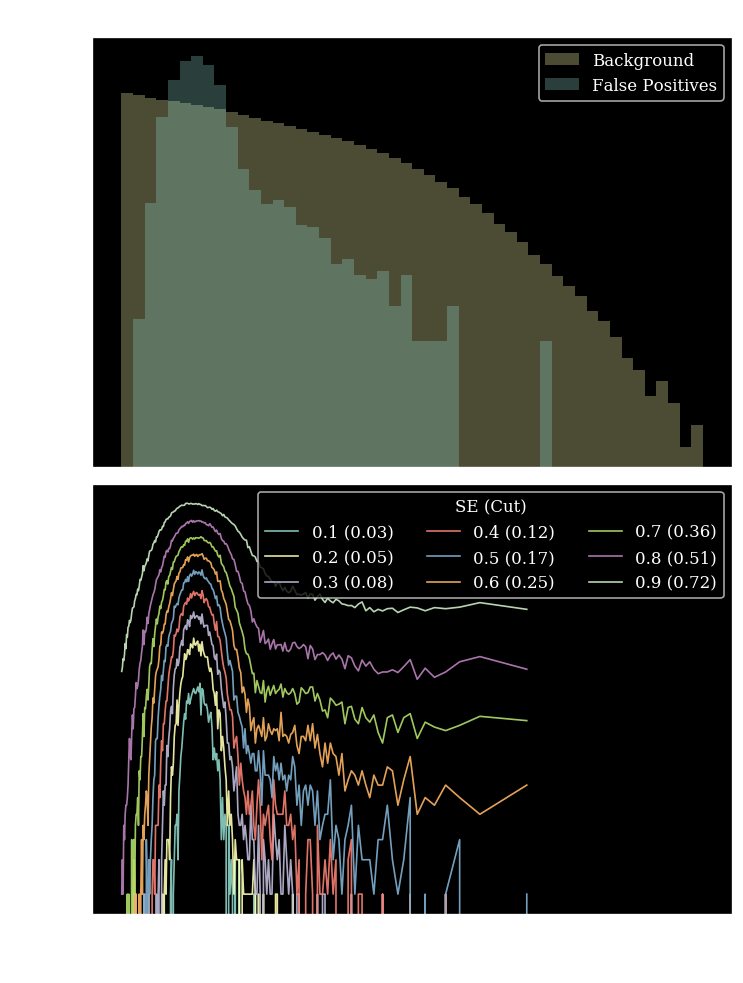

In [6]:
# dense
jsdR50_dense = []
metrics_dense = []
torch.manual_seed(777)
for j in range(10):
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)
    model_L = Model2().to(device)
    optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-3)
    loss =  WeightedMSE(labels=traindataset.labels)
    log=Logger(path+f"MSE_dense({j}).txt")
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    torch.save(model_L.state_dict(),path+f"MSE_dense({j}).pt")
    with torch.no_grad():
        model_L.train(False)
        model_L.to("cpu")
        out=plot_stuff(model=model_L,name=f"MSE_dense({j})",X=X,
               y=test_labels,x_biased=test[:,0],mbins=200,histbins=50,scale="log",
                       f=path+f"MSE_dense({j}).png")
        metrics_dense.append([metrics_train_L,metrics_val_L])
        jsdR50_dense.append(out)

Entering Training...
Epoch:0001/0200  (9.3  s)
 Train: loss:0.3207, acc:65.3% || Val: loss: 0.0974, acc:80.5%, R50: 5.9930, 1/JSD: 18.2253
Epoch:0200/0200  (238.3s)
 Train: loss:0.1795, acc:81.5% || Val: loss: 0.0506, acc:82.8%, R50: 27.4657, 1/JSD: 3.0598


/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


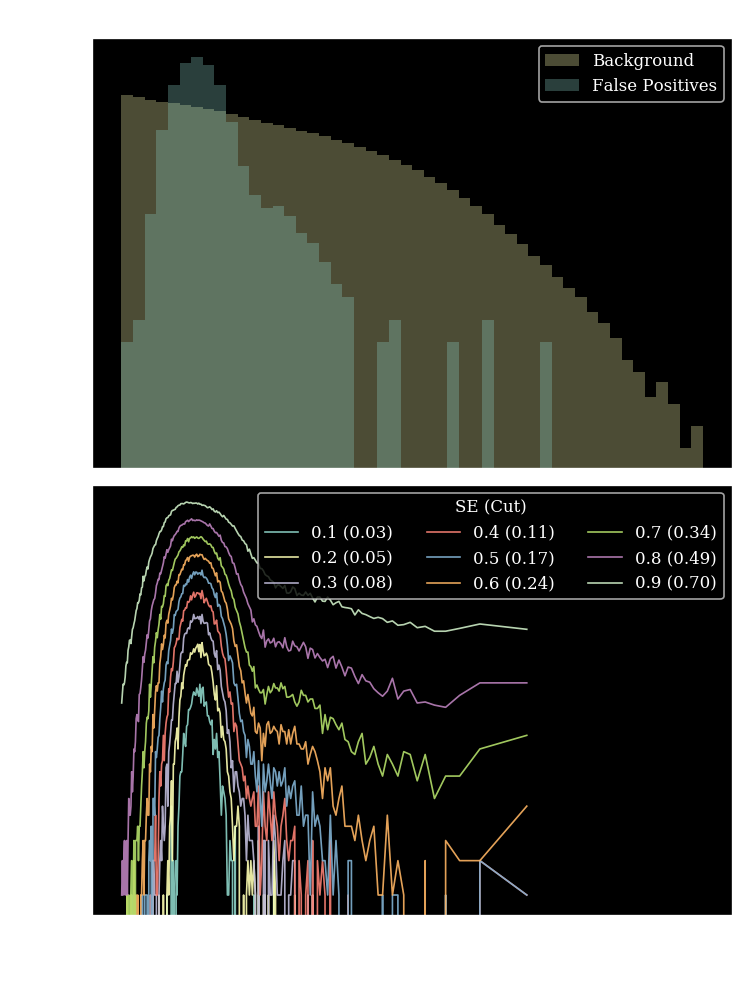

Entering Training...
Epoch:0001/0200  (9.3  s)
 Train: loss:0.3105, acc:67.7% || Val: loss: 0.0973, acc:80.5%, R50: 8.0403, 1/JSD: 132.1574
Epoch:0200/0200  (239.2s)
 Train: loss:0.1794, acc:81.8% || Val: loss: 0.0507, acc:81.8%, R50: 27.3224, 1/JSD: 2.8886


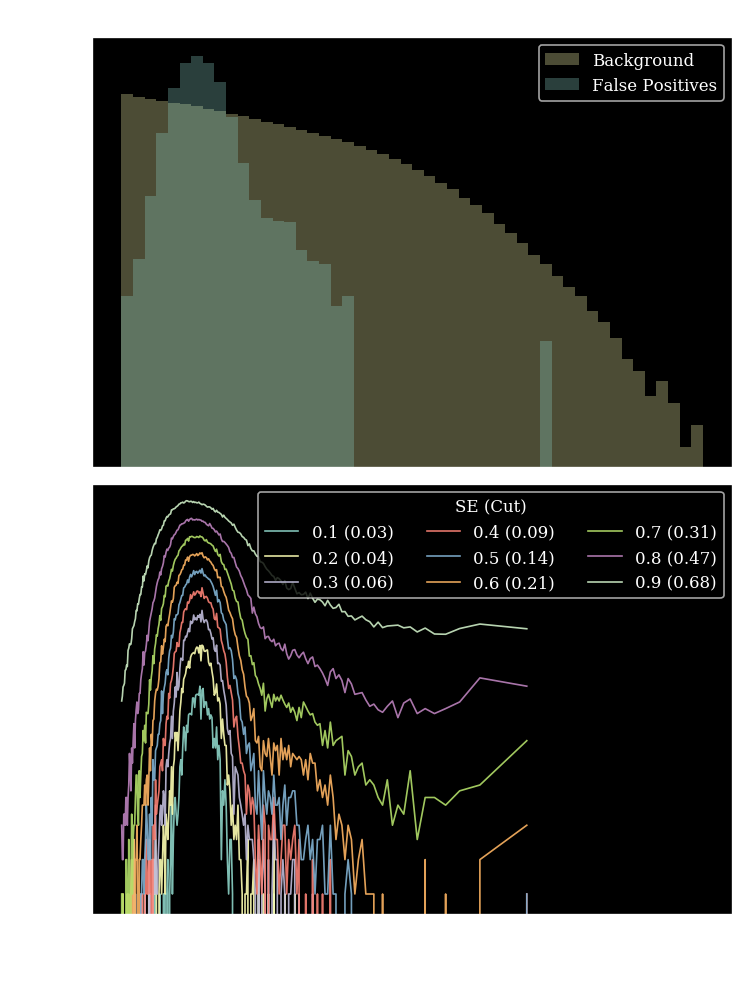

Entering Training...
Epoch:0001/0200  (9.4  s)
 Train: loss:0.3175, acc:69.6% || Val: loss: 0.0973, acc:38.3%, R50: 6.7416, 1/JSD: 36.0025
Epoch:0200/0200  (238.8s)
 Train: loss:0.1778, acc:81.6% || Val: loss: 0.0508, acc:81.6%, R50: 27.4314, 1/JSD: 2.6189


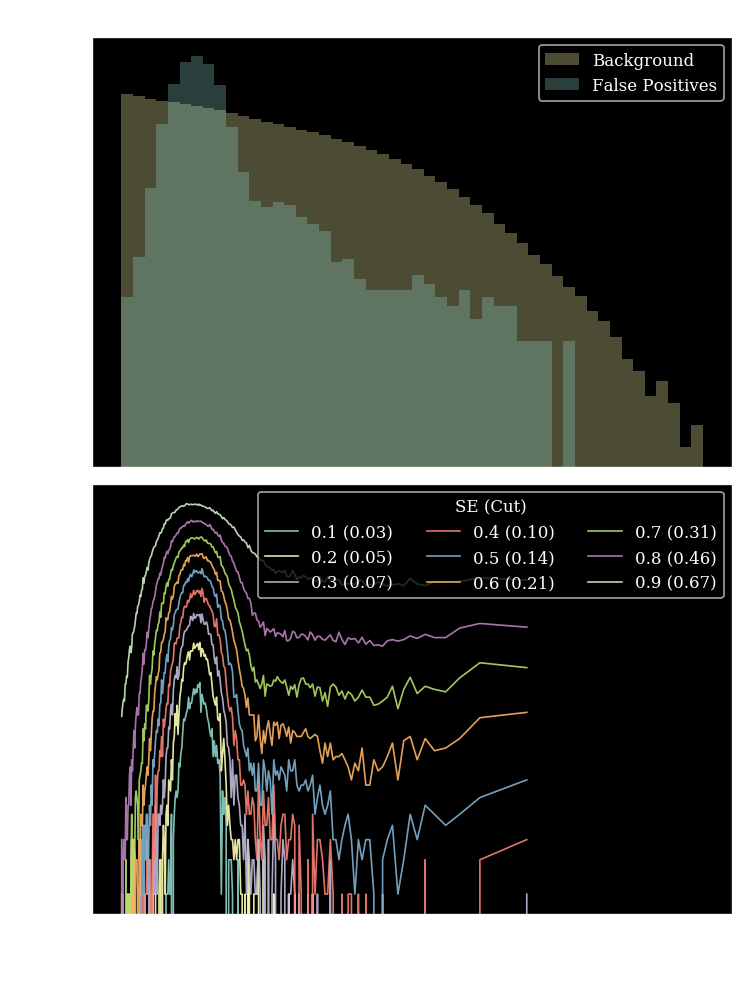

Entering Training...
Epoch:0001/0200  (9.3  s)
 Train: loss:0.3298, acc:66.7% || Val: loss: 0.0974, acc:80.3%, R50: 5.1875, 1/JSD: 59.3731
Epoch:0200/0200  (239.0s)
 Train: loss:0.1802, acc:81.4% || Val: loss: 0.0508, acc:83.4%, R50: 27.2863, 1/JSD: 2.6733


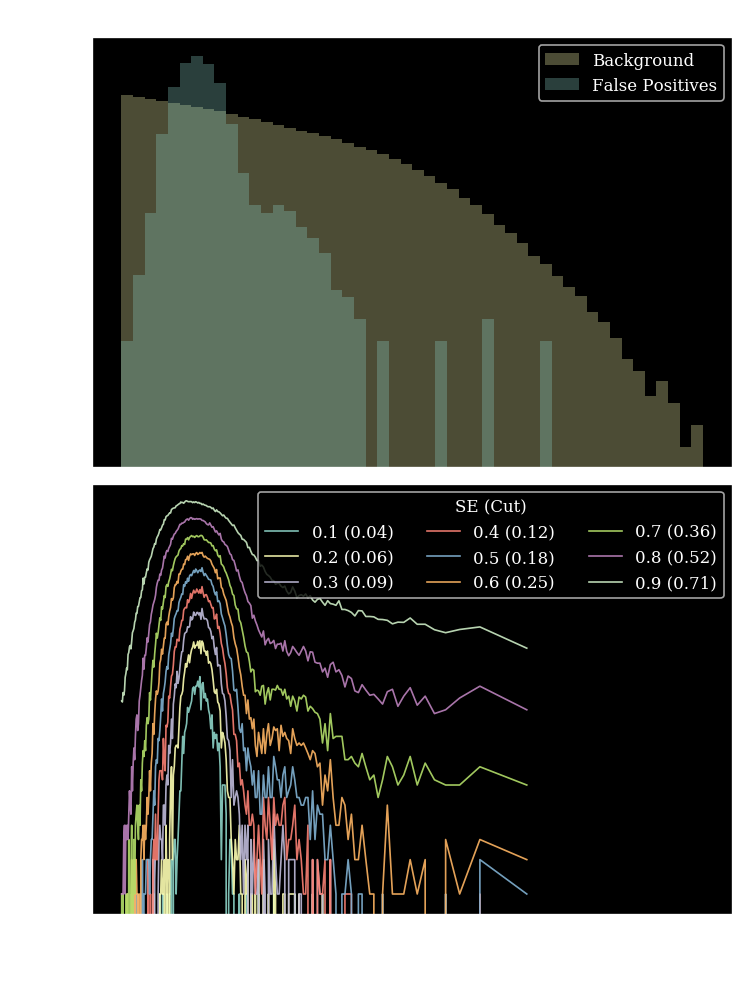

Entering Training...
Epoch:0001/0200  (9.3  s)
 Train: loss:0.3241, acc:56.0% || Val: loss: 0.0976, acc:80.5%, R50: 5.4798, 1/JSD: 15.6938
Epoch:0200/0200  (240.0s)
 Train: loss:0.1793, acc:81.5% || Val: loss: 0.0505, acc:82.2%, R50: 27.3904, 1/JSD: 2.7417


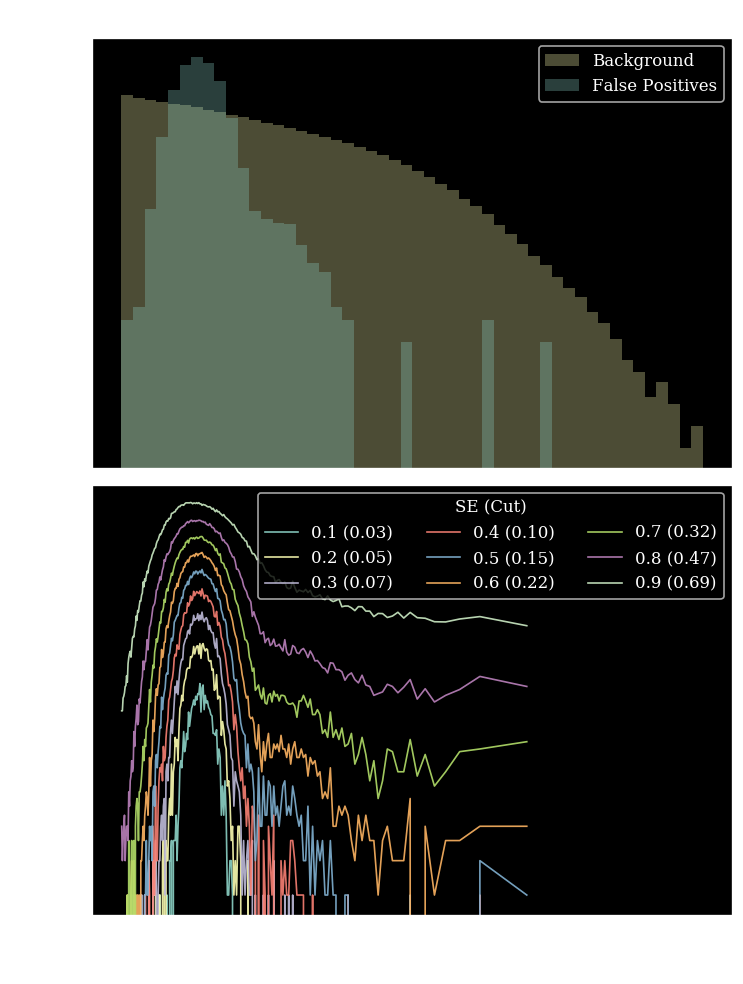

Entering Training...
Epoch:0001/0200  (9.3  s)
 Train: loss:0.3262, acc:65.9% || Val: loss: 0.0974, acc:80.5%, R50: 5.7206, 1/JSD: 21.6337
Epoch:0200/0200  (214.1s)
 Train: loss:0.1786, acc:82.0% || Val: loss: 0.0507, acc:81.7%, R50: 27.2457, 1/JSD: 2.7166


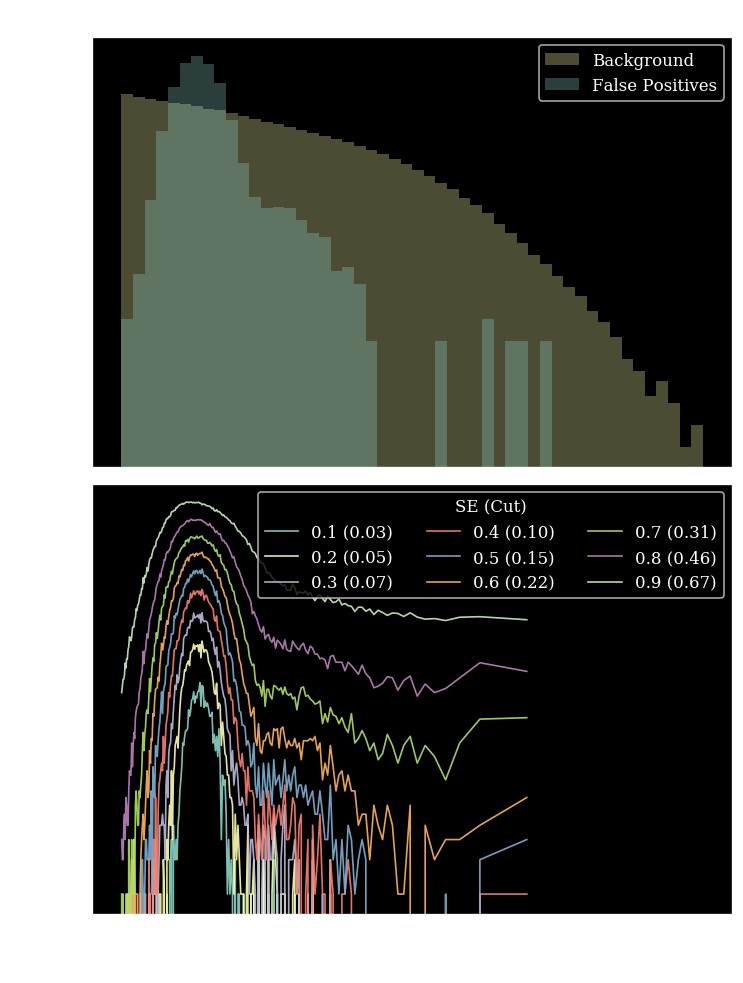

Entering Training...
Epoch:0001/0200  (9.2  s)
 Train: loss:0.3217, acc:60.7% || Val: loss: 0.0975, acc:80.5%, R50: 5.9997, 1/JSD: 27.0066
Epoch:0200/0200  (240.2s)
 Train: loss:0.1786, acc:81.3% || Val: loss: 0.0505, acc:82.6%, R50: 27.2322, 1/JSD: 2.8213


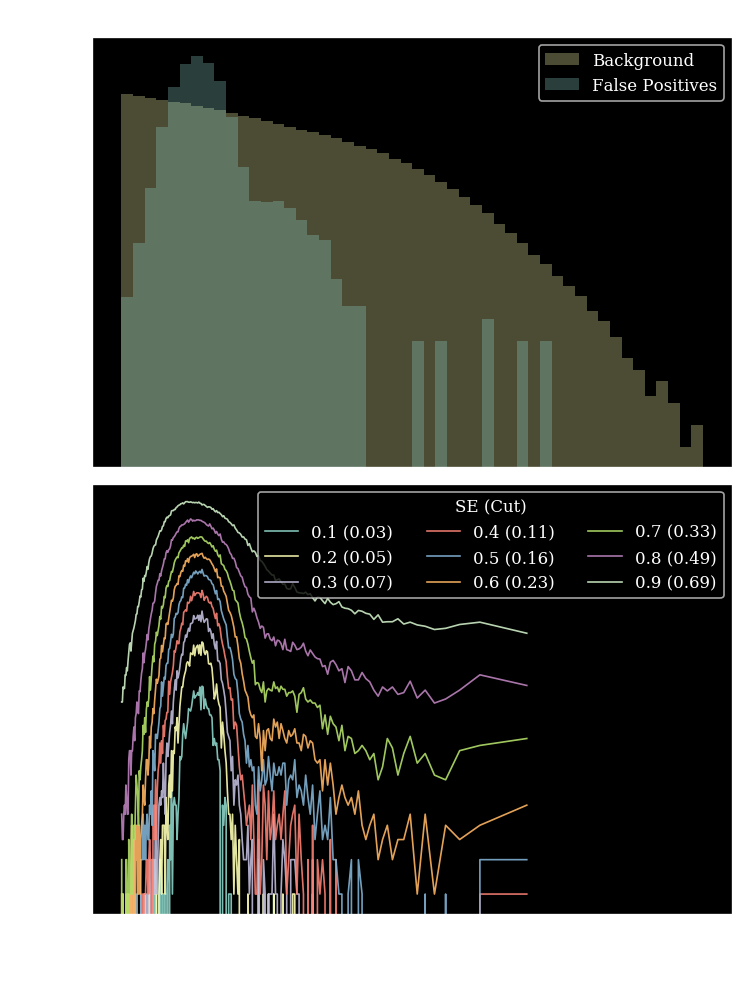

Entering Training...
Epoch:0001/0200  (9.3  s)
 Train: loss:0.3202, acc:70.2% || Val: loss: 0.0974, acc:19.5%, R50: 6.3904, 1/JSD: 26.0935
Epoch:0200/0200  (215.0s)
 Train: loss:0.1802, acc:81.2% || Val: loss: 0.0507, acc:82.9%, R50: 27.3564, 1/JSD: 2.7464


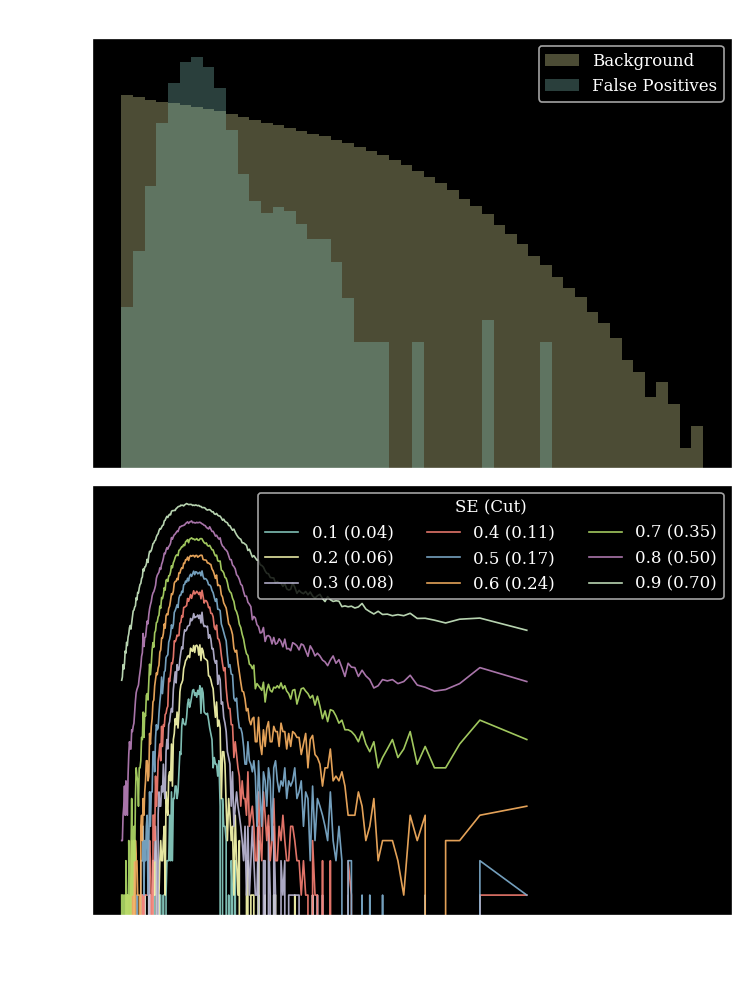

Entering Training...
Epoch:0001/0200  (9.3  s)
 Train: loss:0.3185, acc:73.9% || Val: loss: 0.0976, acc:19.5%, R50: 6.4033, 1/JSD: 58.1416
Epoch:0200/0200  (240.4s)
 Train: loss:0.1793, acc:81.8% || Val: loss: 0.0508, acc:81.7%, R50: 27.0625, 1/JSD: 2.7168


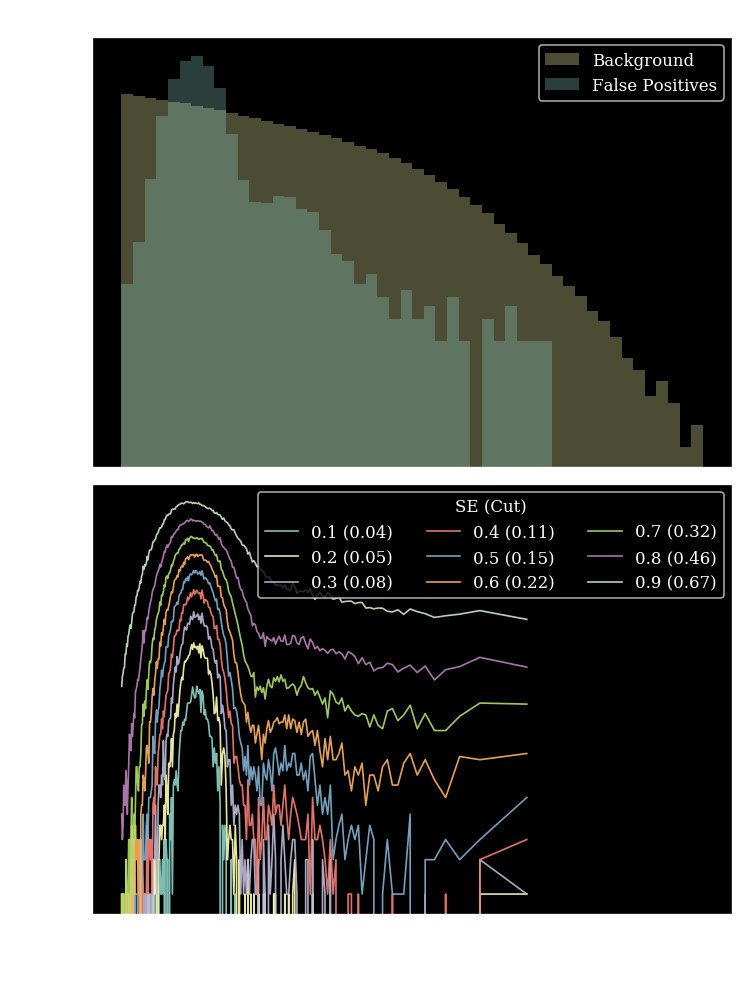

Entering Training...
Epoch:0001/0200  (9.4  s)
 Train: loss:0.3232, acc:70.9% || Val: loss: 0.0974, acc:19.5%, R50: 5.6981, 1/JSD: 21.5844
Epoch:0200/0200  (215.5s)
 Train: loss:0.1801, acc:81.5% || Val: loss: 0.0507, acc:82.0%, R50: 26.8467, 1/JSD: 2.8984


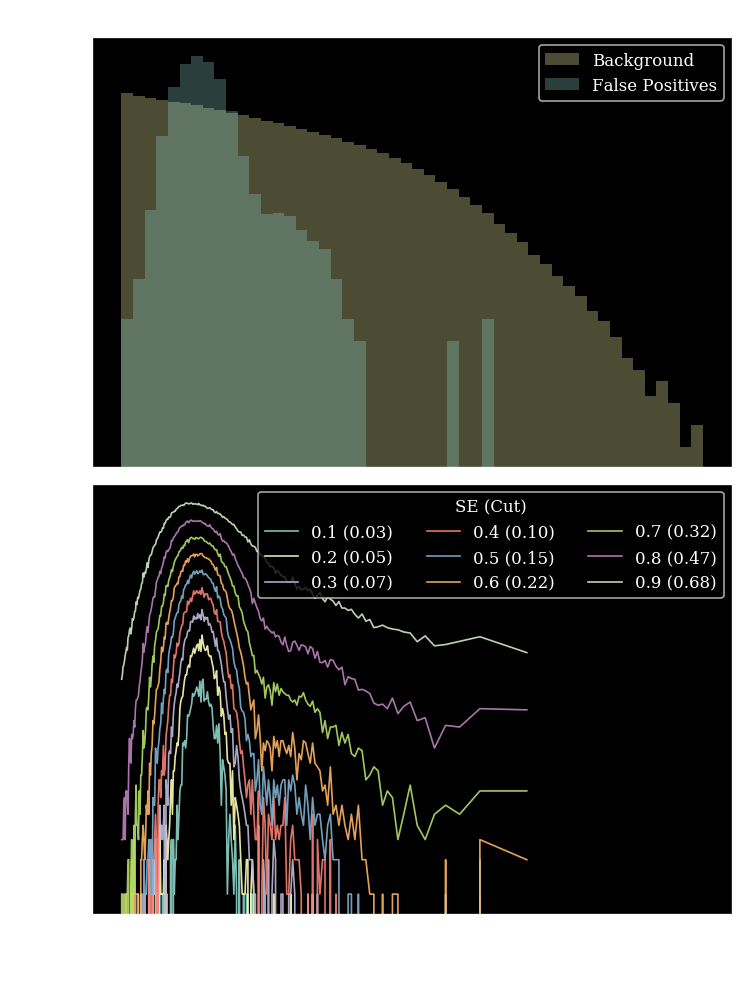

In [7]:
# swish
jsdR50_swish = []
metrics_swish = []
torch.manual_seed(777)
for j in range(10):
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)
    model_L = Model3().to(device)
    optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-3)
    #scheduler = MultiStepLR(optimizer,milestones=[100,150],gamma=0.1)
    loss =  WeightedMSE(labels=traindataset.labels)
    log=Logger(path+f"MSE_swish({j}).txt")
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    torch.save(model_L.state_dict(),path+f"MSE_swish({j}).pt")
    with torch.no_grad():
        model_L.train(False)
        model_L.to("cpu")
        out=plot_stuff(model=model_L,name=f"MSE_swish({j})",X=X,
               y=test_labels,x_biased=test[:,0],mbins=200,histbins=50,scale="log",
                       f=path+f"MSE_swish({j}).png")
        metrics_swish.append([metrics_train_L,metrics_val_L])
        jsdR50_swish.append(out)

Entering Training...
Epoch:0001/0200  (9.3  s)
 Train: loss:0.3222, acc:64.5% || Val: loss: 0.0973, acc:80.5%, R50: 6.6481, 1/JSD: 43.4416
Epoch:0200/0200  (248.3s)
 Train: loss:0.1784, acc:81.7% || Val: loss: 0.0509, acc:81.5%, R50: 27.0093, 1/JSD: 3.7587


/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


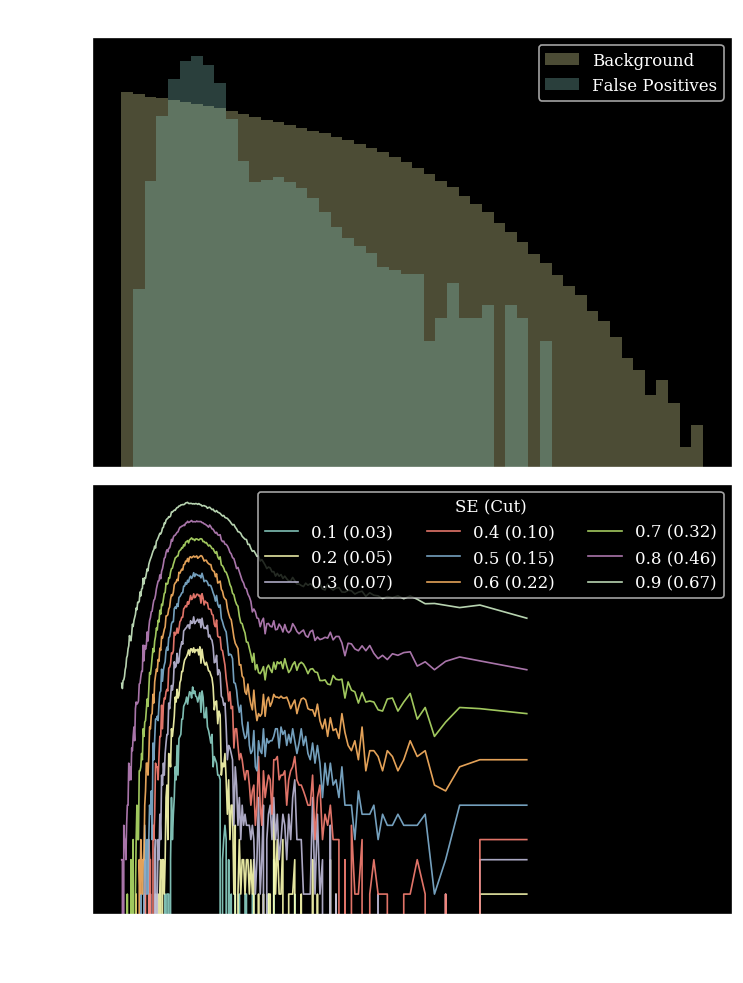

Entering Training...
Epoch:0001/0200  (9.2  s)
 Train: loss:0.3192, acc:62.1% || Val: loss: 0.0973, acc:80.5%, R50: 7.4791, 1/JSD: 10.7723
Epoch:0200/0200  (255.1s)
 Train: loss:0.1786, acc:81.9% || Val: loss: 0.0508, acc:81.6%, R50: 27.0470, 1/JSD: 2.7846


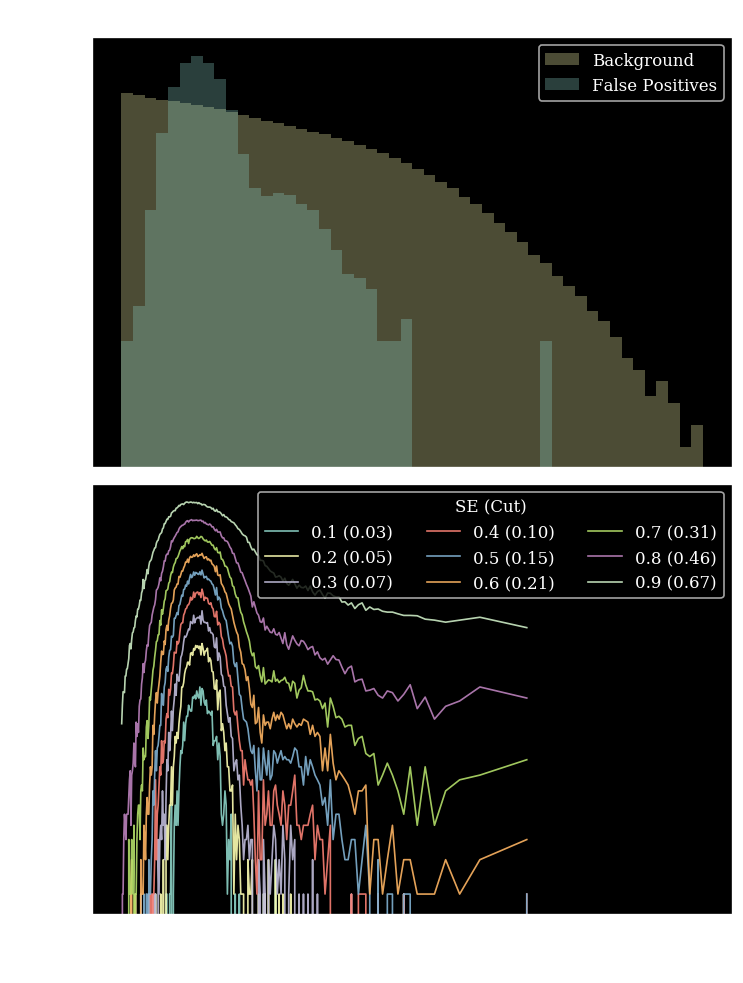

Entering Training...
Epoch:0001/0200  (9.7  s)
 Train: loss:0.3248, acc:69.9% || Val: loss: 0.0973, acc:80.5%, R50: 6.5446, 1/JSD: 52.7710
Epoch:0200/0200  (220.0s)
 Train: loss:0.1760, acc:81.7% || Val: loss: 0.0509, acc:81.1%, R50: 27.2682, 1/JSD: 2.7201


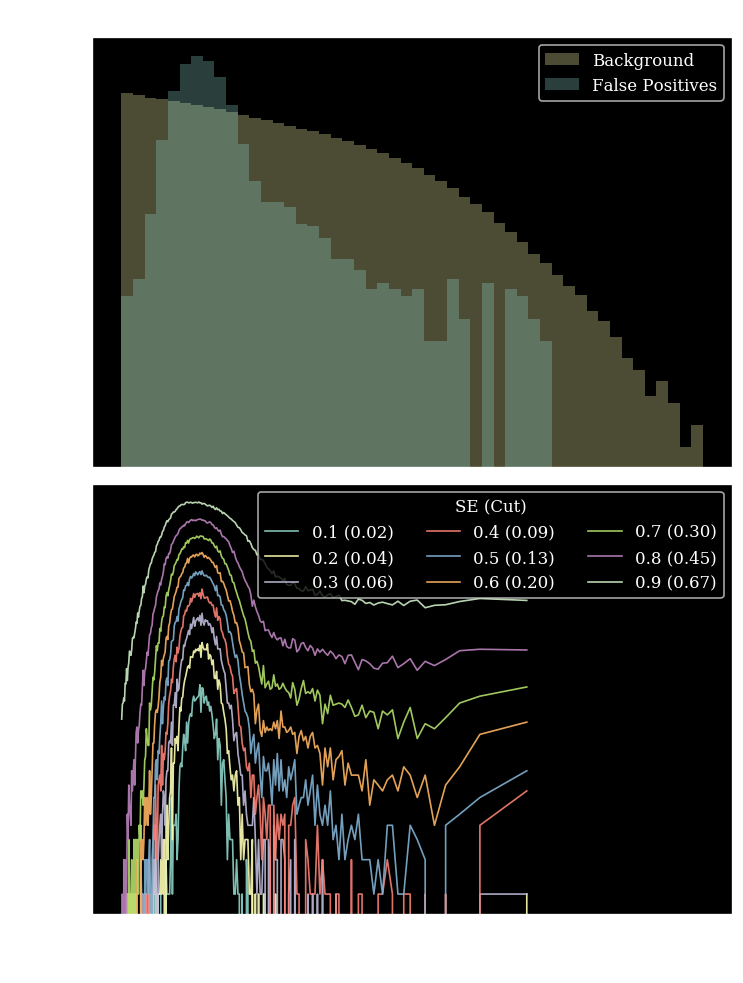

Entering Training...
Epoch:0001/0200  (9.4  s)
 Train: loss:0.3279, acc:67.1% || Val: loss: 0.0973, acc:80.5%, R50: 5.2037, 1/JSD: 31.7101
Epoch:0200/0200  (263.4s)
 Train: loss:0.1784, acc:81.7% || Val: loss: 0.0509, acc:82.3%, R50: 26.9542, 1/JSD: 2.5738


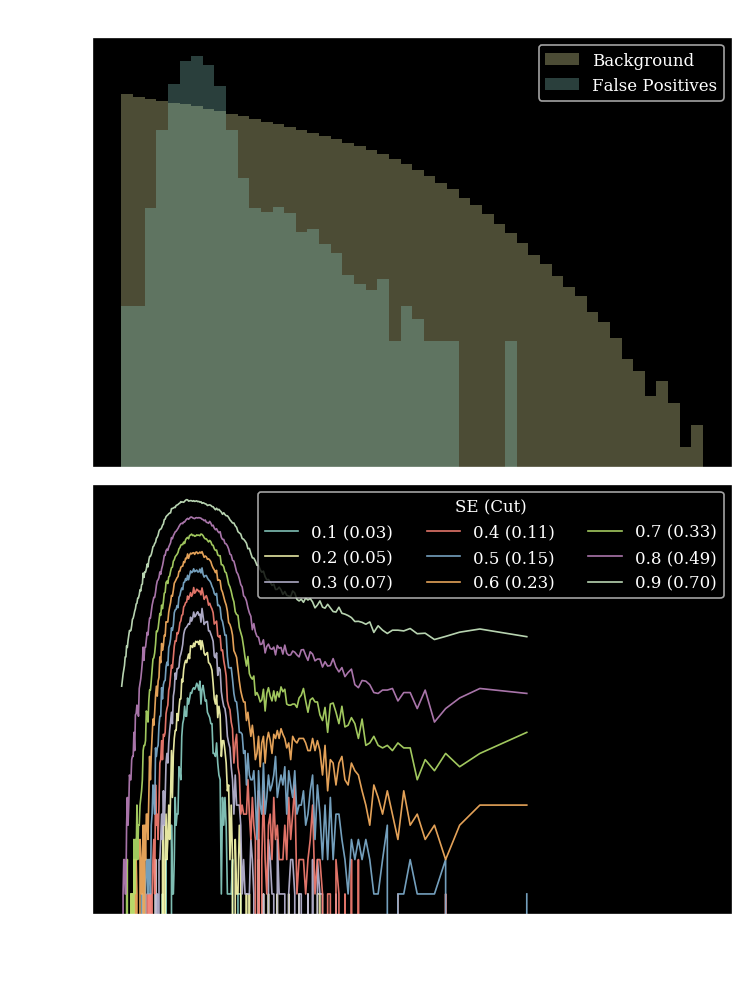

Entering Training...
Epoch:0001/0200  (9.2  s)
 Train: loss:0.3272, acc:41.5% || Val: loss: 0.0975, acc:80.5%, R50: 7.7262, 1/JSD: 44.4081
Epoch:0200/0200  (228.5s)
 Train: loss:0.1783, acc:81.8% || Val: loss: 0.0508, acc:83.0%, R50: 27.2165, 1/JSD: 3.3490


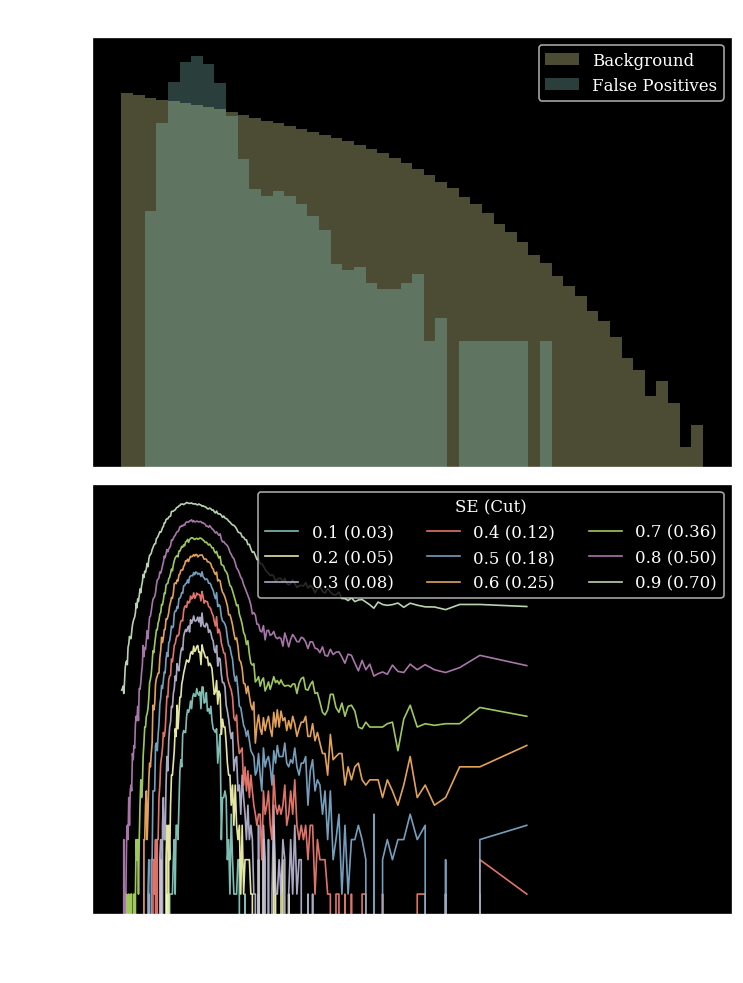

Entering Training...
Epoch:0001/0200  (9.4  s)
 Train: loss:0.3251, acc:67.6% || Val: loss: 0.0972, acc:80.5%, R50: 7.7549, 1/JSD: 52.0305
Epoch:0200/0200  (272.5s)
 Train: loss:0.1770, acc:81.9% || Val: loss: 0.0508, acc:82.8%, R50: 27.0958, 1/JSD: 2.5718


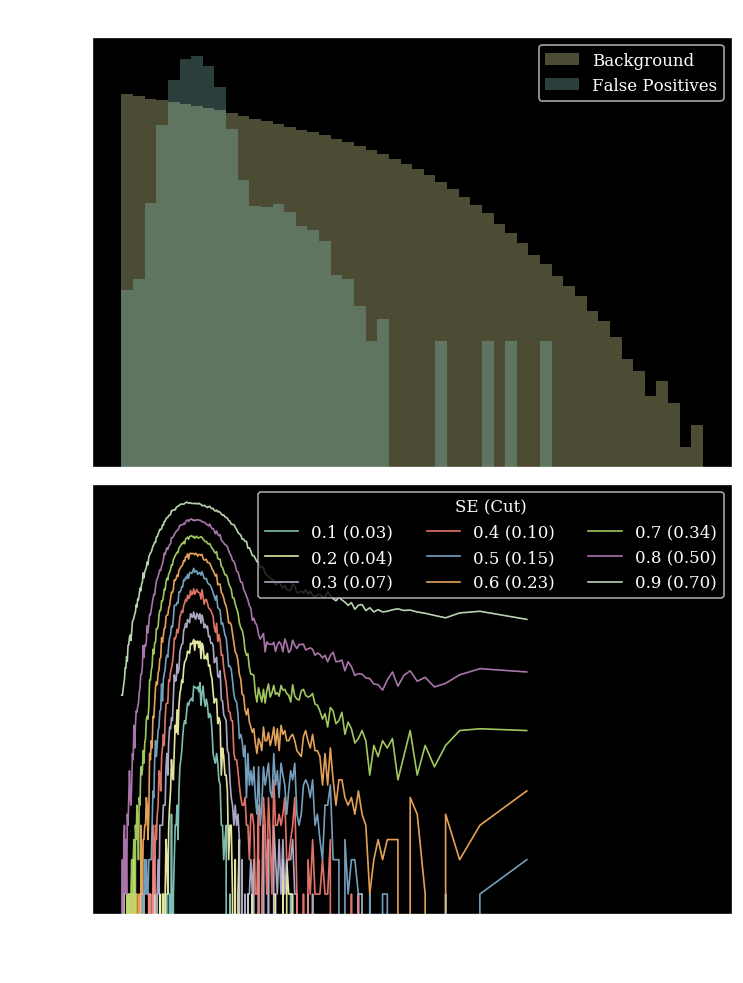

Entering Training...
Epoch:0001/0200  (9.1  s)
 Train: loss:0.3251, acc:64.1% || Val: loss: 0.0976, acc:80.5%, R50: 5.8636, 1/JSD: 68.1935
Epoch:0200/0200  (270.5s)
 Train: loss:0.1770, acc:81.7% || Val: loss: 0.0508, acc:81.9%, R50: 27.0315, 1/JSD: 3.5011


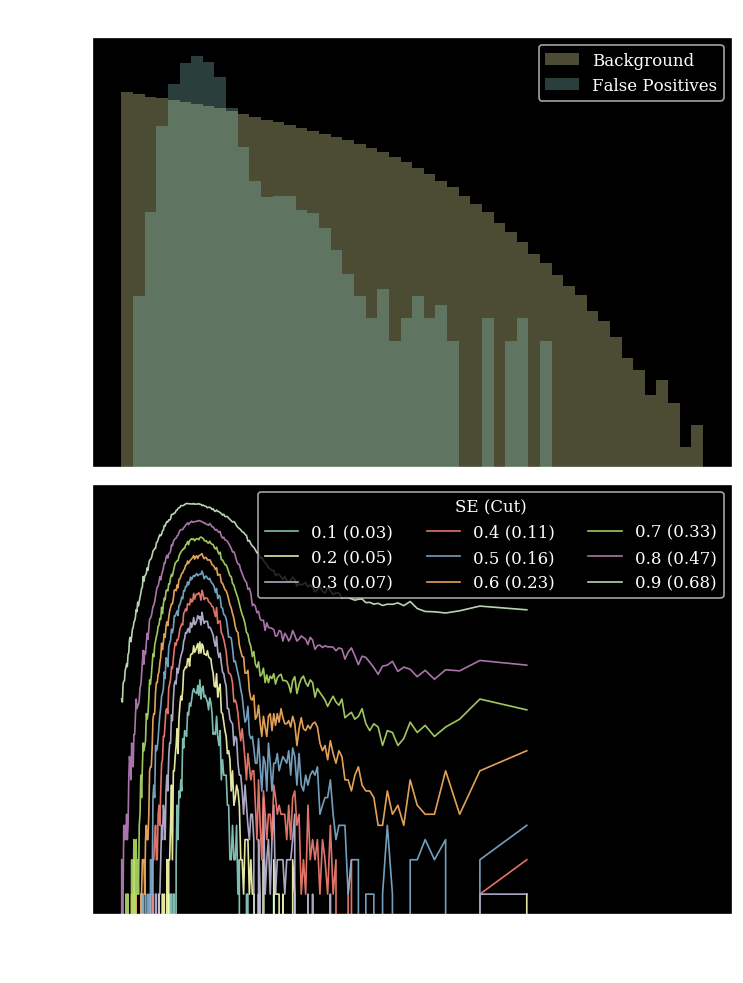

Entering Training...
Epoch:0001/0200  (9.1  s)
 Train: loss:0.3293, acc:72.5% || Val: loss: 0.0974, acc:19.5%, R50: 5.3148, 1/JSD: 32.7729
Epoch:0200/0200  (271.7s)
 Train: loss:0.1783, acc:81.4% || Val: loss: 0.0512, acc:80.5%, R50: 26.8642, 1/JSD: 2.9664


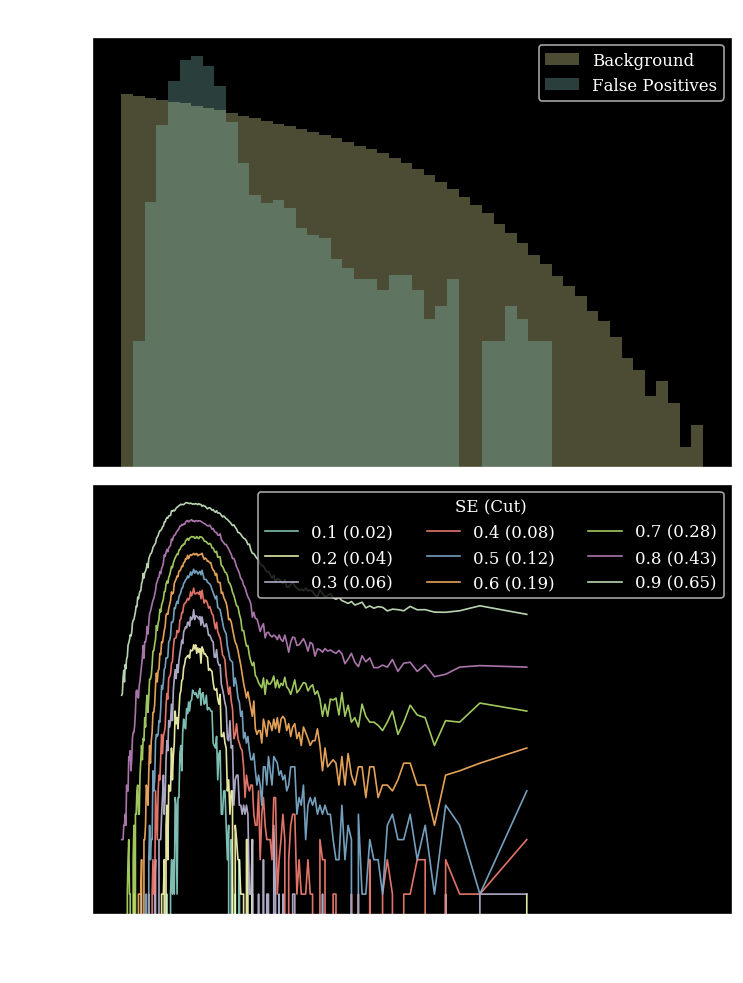

Entering Training...
Epoch:0001/0200  (9.4  s)
 Train: loss:0.3253, acc:73.9% || Val: loss: 0.0976, acc:19.5%, R50: 7.1393, 1/JSD: 123.2772
Epoch:0200/0200  (273.4s)
 Train: loss:0.1778, acc:82.1% || Val: loss: 0.0513, acc:81.0%, R50: 26.2906, 1/JSD: 2.6489


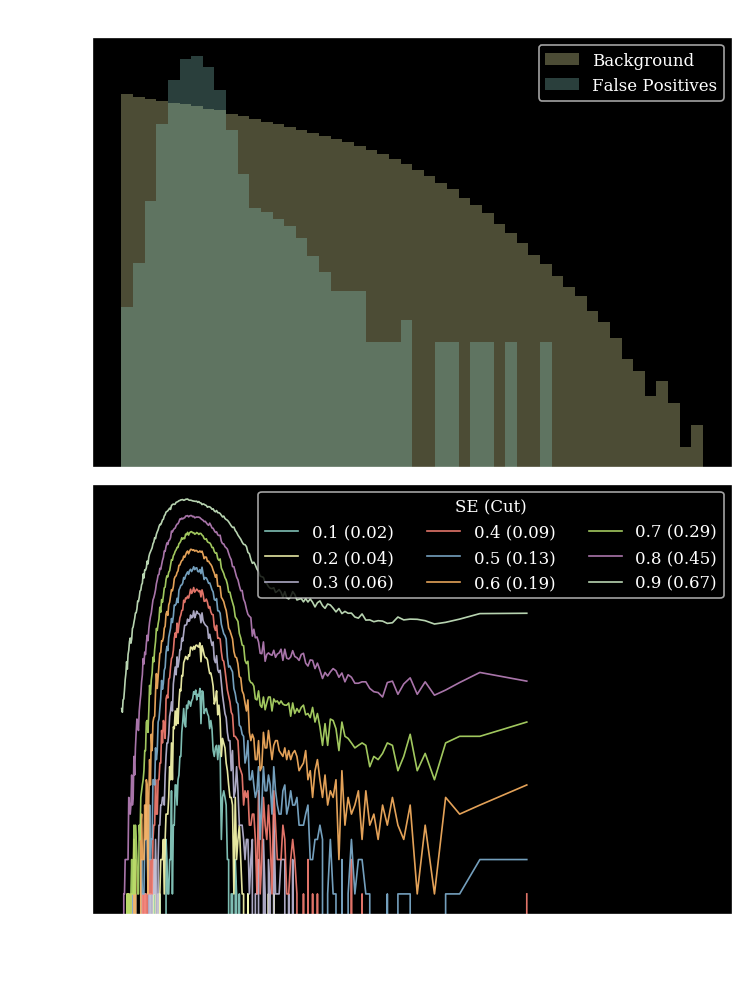

Entering Training...
Epoch:0001/0200  (9.3  s)
 Train: loss:0.3240, acc:71.7% || Val: loss: 0.0972, acc:19.5%, R50: 5.1552, 1/JSD: 15.5615
Epoch:0200/0200  (272.5s)
 Train: loss:0.1789, acc:81.8% || Val: loss: 0.0511, acc:80.8%, R50: 27.0425, 1/JSD: 2.7783


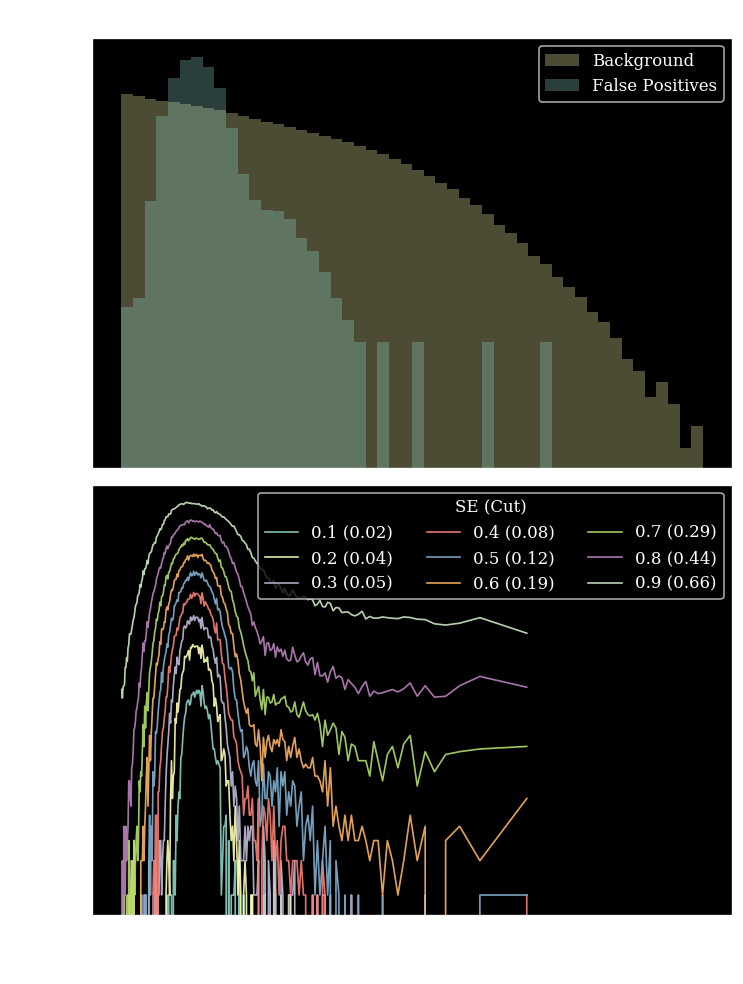

In [8]:
# simple
jsdR50_simple = []
metrics_simple = []
torch.manual_seed(777)
for j in range(10):
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)
    model_L = Model().to(device)
    optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-3)
    #scheduler = MultiStepLR(optimizer,milestones=[100,150],gamma=0.1)
    loss =  WeightedMSE(labels=traindataset.labels)
    log=Logger(path+f"MSE_simple({j}).txt")
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    torch.save(model_L.state_dict(),path+f"MSE_simple({j}).pt")
    with torch.no_grad():
        model_L.train(False)
        model_L.to("cpu")
        out=plot_stuff(model=model_L,name=f"MSE_simple({j})",X=X,
               y=test_labels,x_biased=test[:,0],mbins=200,histbins=50,scale="log",
                       f=path+f"MSE_simple({j}).png")
        metrics_simple.append([metrics_train_L,metrics_val_L])
        jsdR50_simple.append(out)

Entering Training...
Epoch:0001/0200  (9.5  s)
 Train: loss:0.2824, acc:68.5% || Val: loss: 0.0960, acc:80.5%, R50: 10.0908, 1/JSD: 18.6221
Epoch:0200/0200  (270.1s)
 Train: loss:0.1773, acc:81.9% || Val: loss: 0.0506, acc:82.1%, R50: 27.3156, 1/JSD: 3.0751


/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


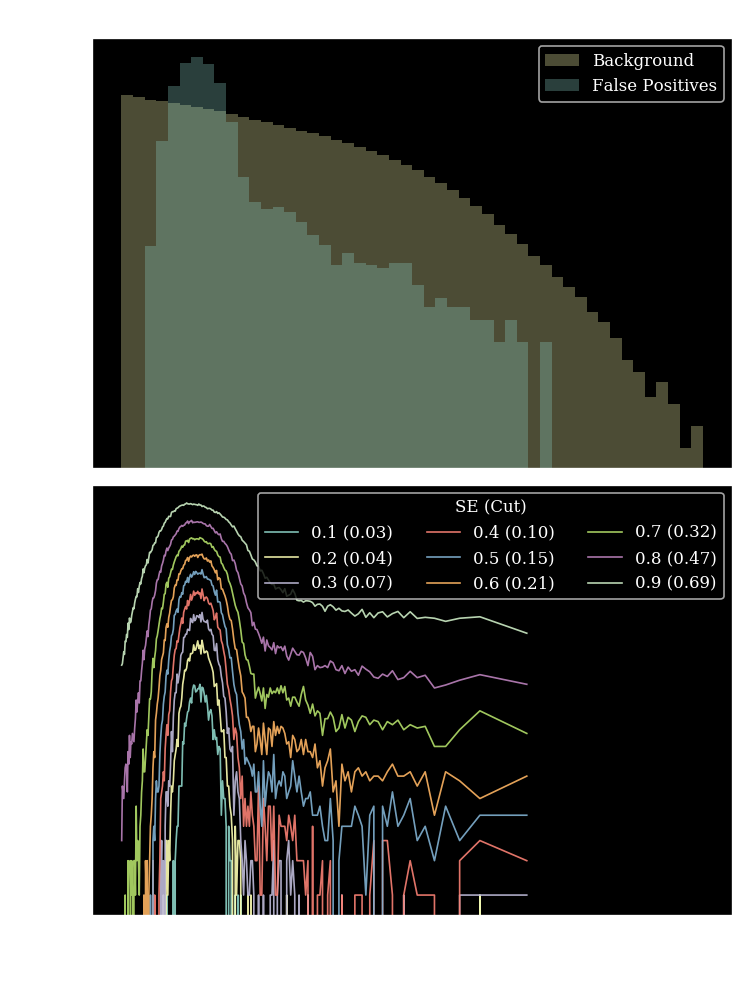

Entering Training...
Epoch:0001/0200  (9.4  s)
 Train: loss:0.2784, acc:69.1% || Val: loss: 0.0955, acc:80.5%, R50: 8.9850, 1/JSD: 13.7551
Epoch:0200/0200  (237.0s)
 Train: loss:0.1764, acc:82.1% || Val: loss: 0.0509, acc:81.5%, R50: 26.7835, 1/JSD: 2.6583


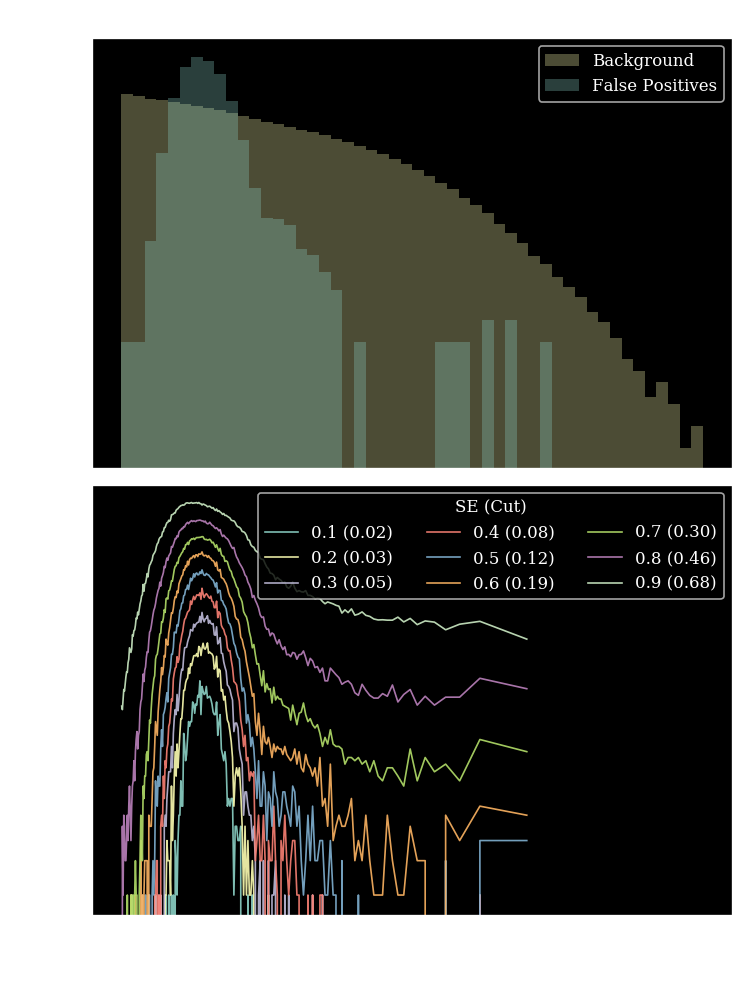

Entering Training...
Epoch:0001/0200  (9.4  s)
 Train: loss:0.2848, acc:69.9% || Val: loss: 0.0958, acc:80.5%, R50: 9.4724, 1/JSD: 26.3426
Epoch:0200/0200  (270.0s)
 Train: loss:0.1750, acc:81.8% || Val: loss: 0.0511, acc:80.7%, R50: 26.9740, 1/JSD: 2.8914


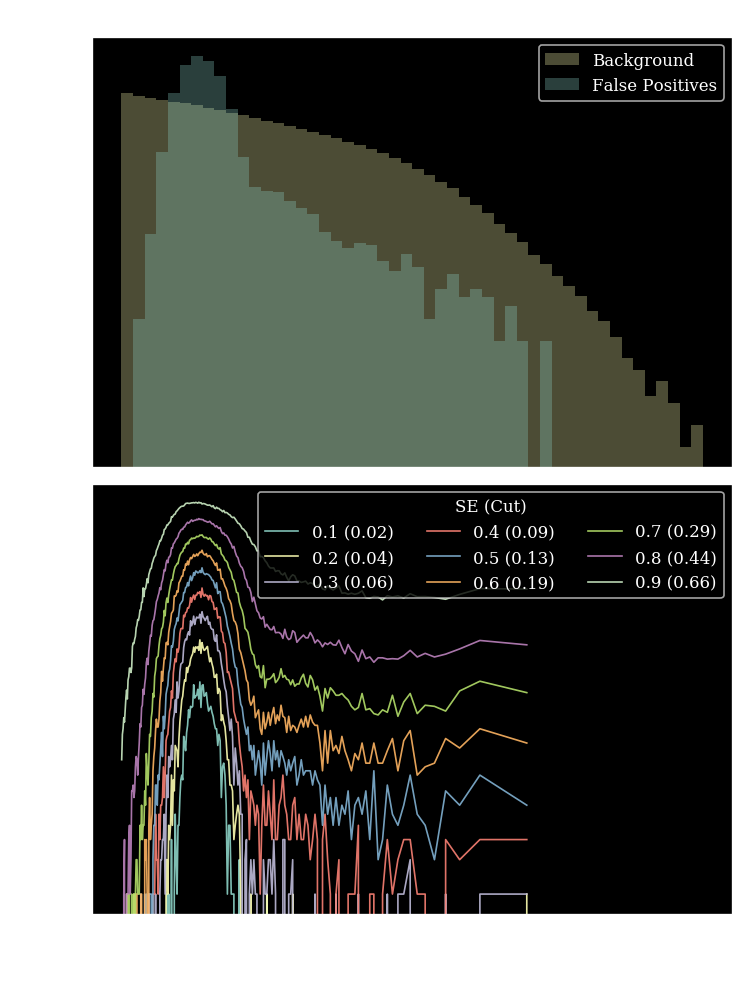

Entering Training...
Epoch:0001/0200  (9.4  s)
 Train: loss:0.2807, acc:69.6% || Val: loss: 0.0954, acc:78.3%, R50: 8.6769, 1/JSD: 69.4349
Epoch:0200/0200  (270.7s)
 Train: loss:0.1778, acc:81.9% || Val: loss: 0.0510, acc:82.3%, R50: 26.2530, 1/JSD: 2.9796


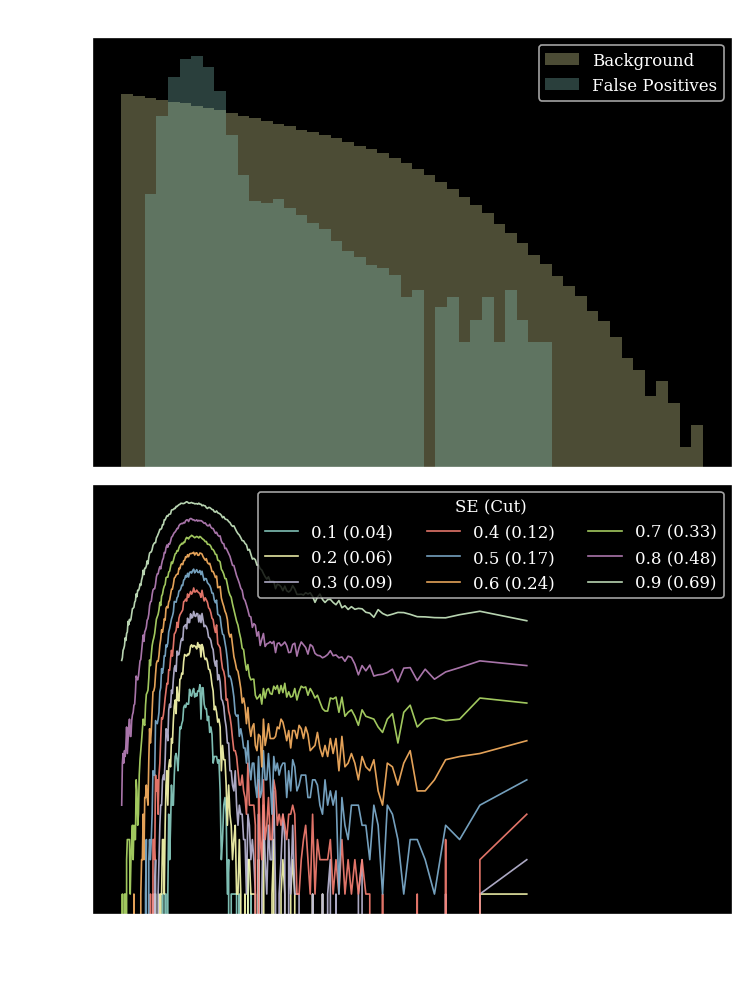

Entering Training...
Epoch:0001/0200  (9.3  s)
 Train: loss:0.2874, acc:68.1% || Val: loss: 0.0961, acc:80.5%, R50: 8.7000, 1/JSD: 45.5139
Epoch:0200/0200  (269.3s)
 Train: loss:0.1761, acc:81.9% || Val: loss: 0.0510, acc:81.4%, R50: 26.0478, 1/JSD: 2.7002


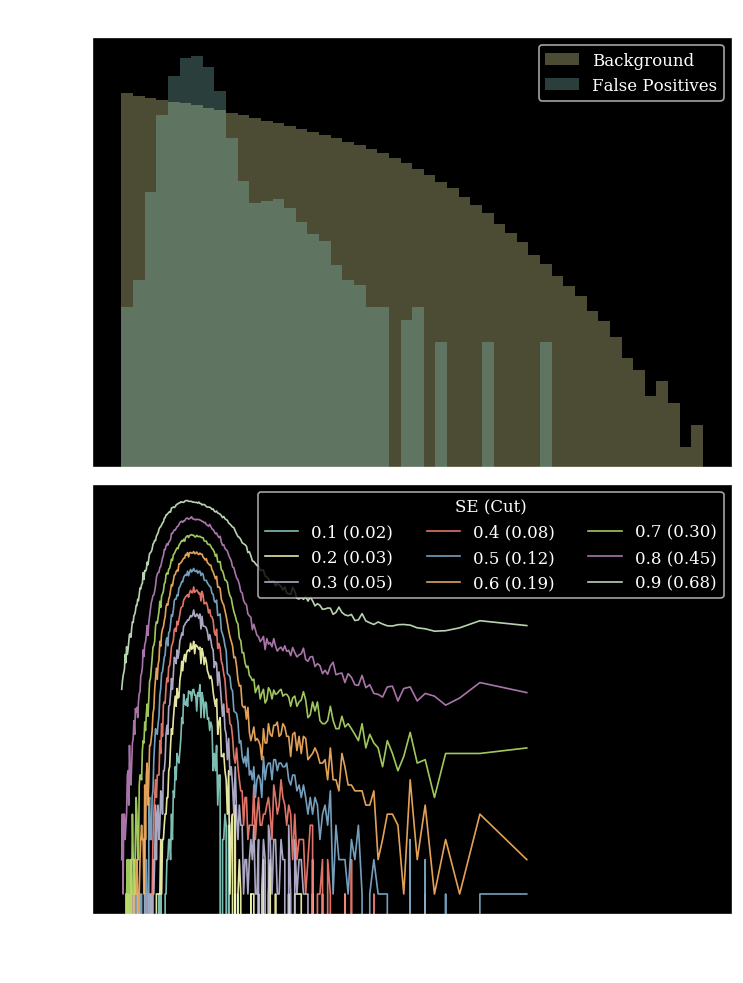

Entering Training...
Epoch:0001/0200  (9.5  s)
 Train: loss:0.2782, acc:69.0% || Val: loss: 0.0947, acc:77.1%, R50: 8.4330, 1/JSD: 87.0405
Epoch:0200/0200  (266.9s)
 Train: loss:0.1755, acc:82.1% || Val: loss: 0.0507, acc:82.1%, R50: 26.9388, 1/JSD: 2.9459


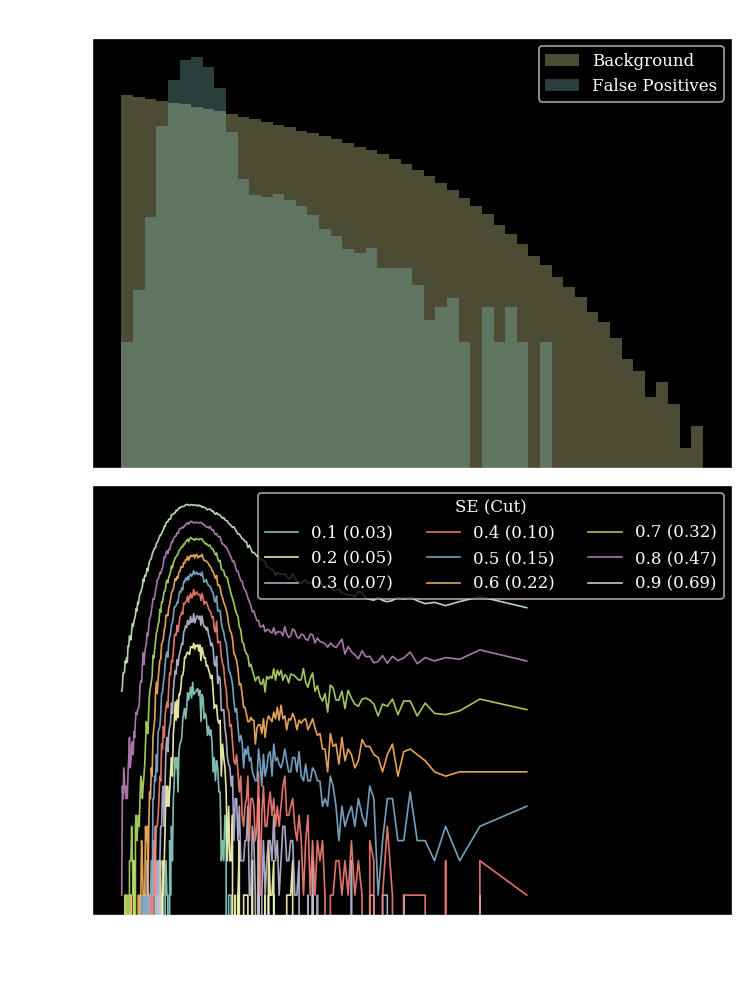

Entering Training...
Epoch:0001/0200  (9.3  s)
 Train: loss:0.2700, acc:72.1% || Val: loss: 0.0961, acc:80.5%, R50: 9.4605, 1/JSD: 19.8020
Epoch:0200/0200  (269.0s)
 Train: loss:0.1755, acc:82.0% || Val: loss: 0.0507, acc:82.3%, R50: 26.9961, 1/JSD: 2.6279


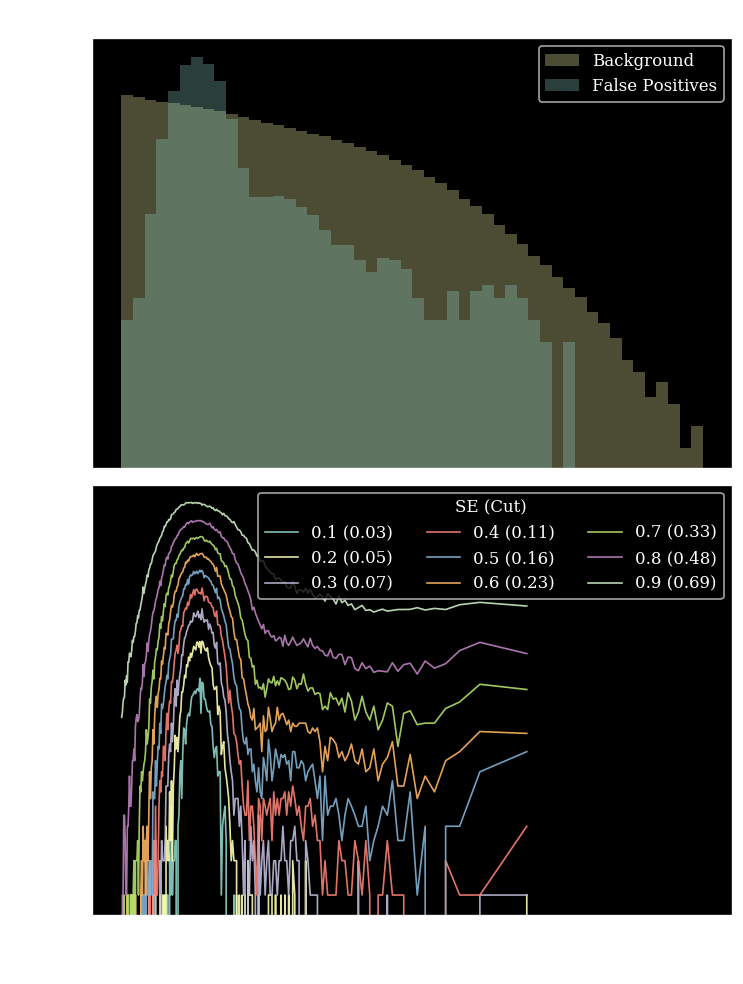

Entering Training...
Epoch:0001/0200  (9.4  s)
 Train: loss:0.2826, acc:69.7% || Val: loss: 0.0950, acc:26.1%, R50: 6.7687, 1/JSD: 43.6062
Epoch:0200/0200  (269.6s)
 Train: loss:0.1774, acc:81.5% || Val: loss: 0.0507, acc:81.3%, R50: 27.1270, 1/JSD: 3.0984


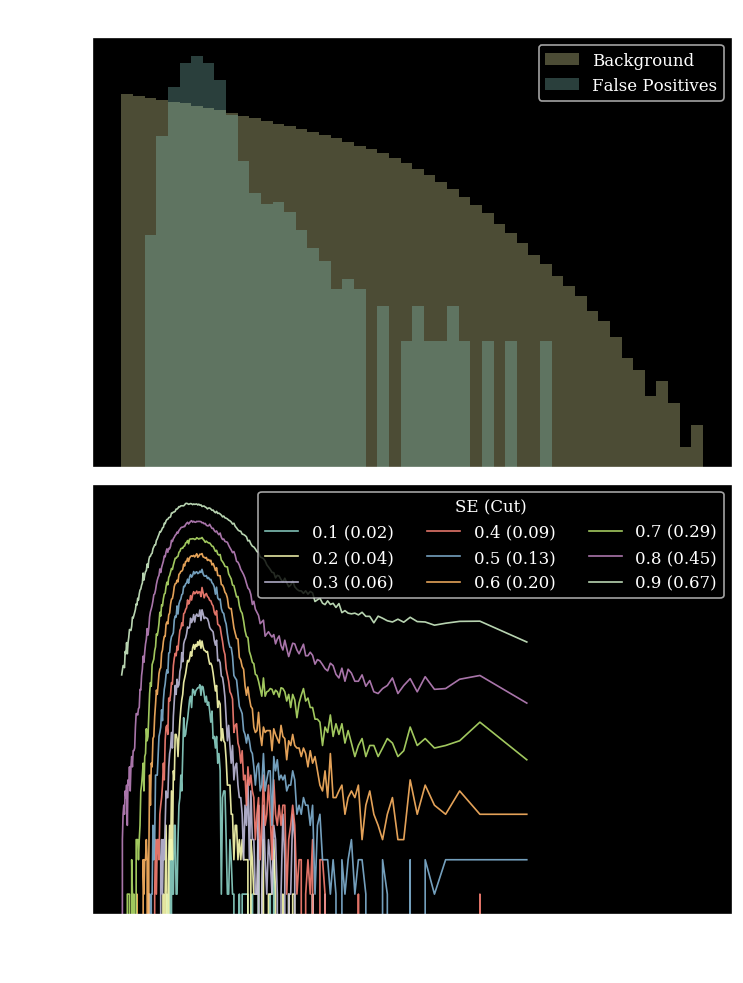

Entering Training...
Epoch:0001/0200  (9.2  s)
 Train: loss:0.2727, acc:71.3% || Val: loss: 0.0958, acc:78.0%, R50: 9.4651, 1/JSD: 20.2360
Epoch:0200/0200  (272.3s)
 Train: loss:0.1761, acc:82.3% || Val: loss: 0.0515, acc:79.7%, R50: 26.4720, 1/JSD: 2.5580


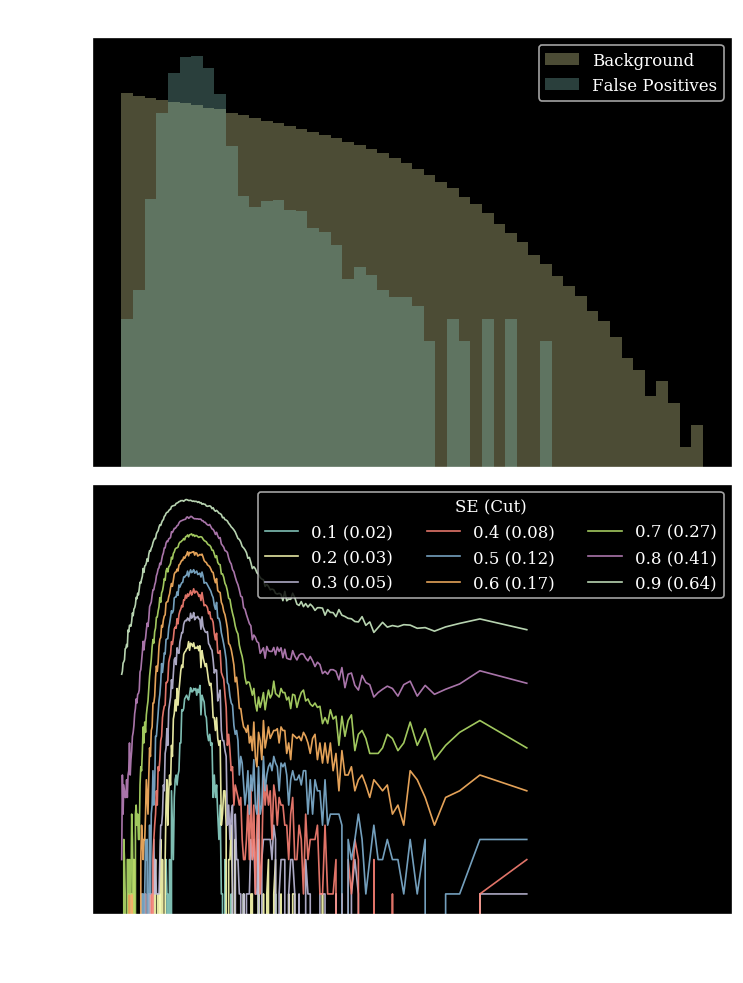

Entering Training...
Epoch:0001/0200  (9.3  s)
 Train: loss:0.2734, acc:70.9% || Val: loss: 0.0944, acc:40.6%, R50: 9.0924, 1/JSD: 36.1795
Epoch:0200/0200  (270.8s)
 Train: loss:0.1779, acc:81.9% || Val: loss: 0.0513, acc:81.1%, R50: 26.0478, 1/JSD: 3.4962


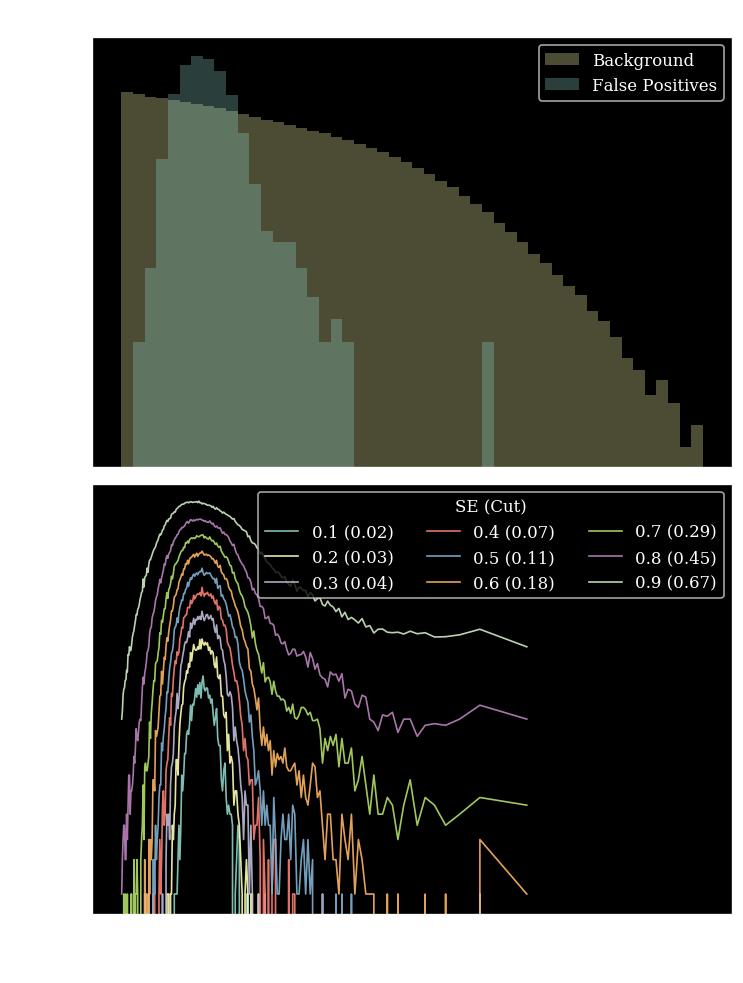

In [10]:
# lr
jsdR50_lr = []
metrics_lr = []
torch.manual_seed(777)
for j in range(10):
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)
    model_L = Model().to(device)
    optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-3)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 1e-1, epochs=200, steps_per_epoch=5, pct_start=0.3, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=25.0, final_div_factor=10000.0, last_epoch=-1)
    loss =  WeightedMSE(labels=traindataset.labels)
    log=Logger(path+f"MSE_lr({j}).txt")
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    torch.save(model_L.state_dict(),path+f"MSE_lr({j}).pt")
    with torch.no_grad():
        model_L.train(False)
        model_L.to("cpu")
        out=plot_stuff(model=model_L,name=f"MSE_lr({j})",X=X,
               y=test_labels,x_biased=test[:,0],mbins=200,histbins=50,scale="log",
                       f=path+f"MSE_lr({j}).png")
        metrics_lr.append([metrics_train_L,metrics_val_L])
        jsdR50_lr.append(out)

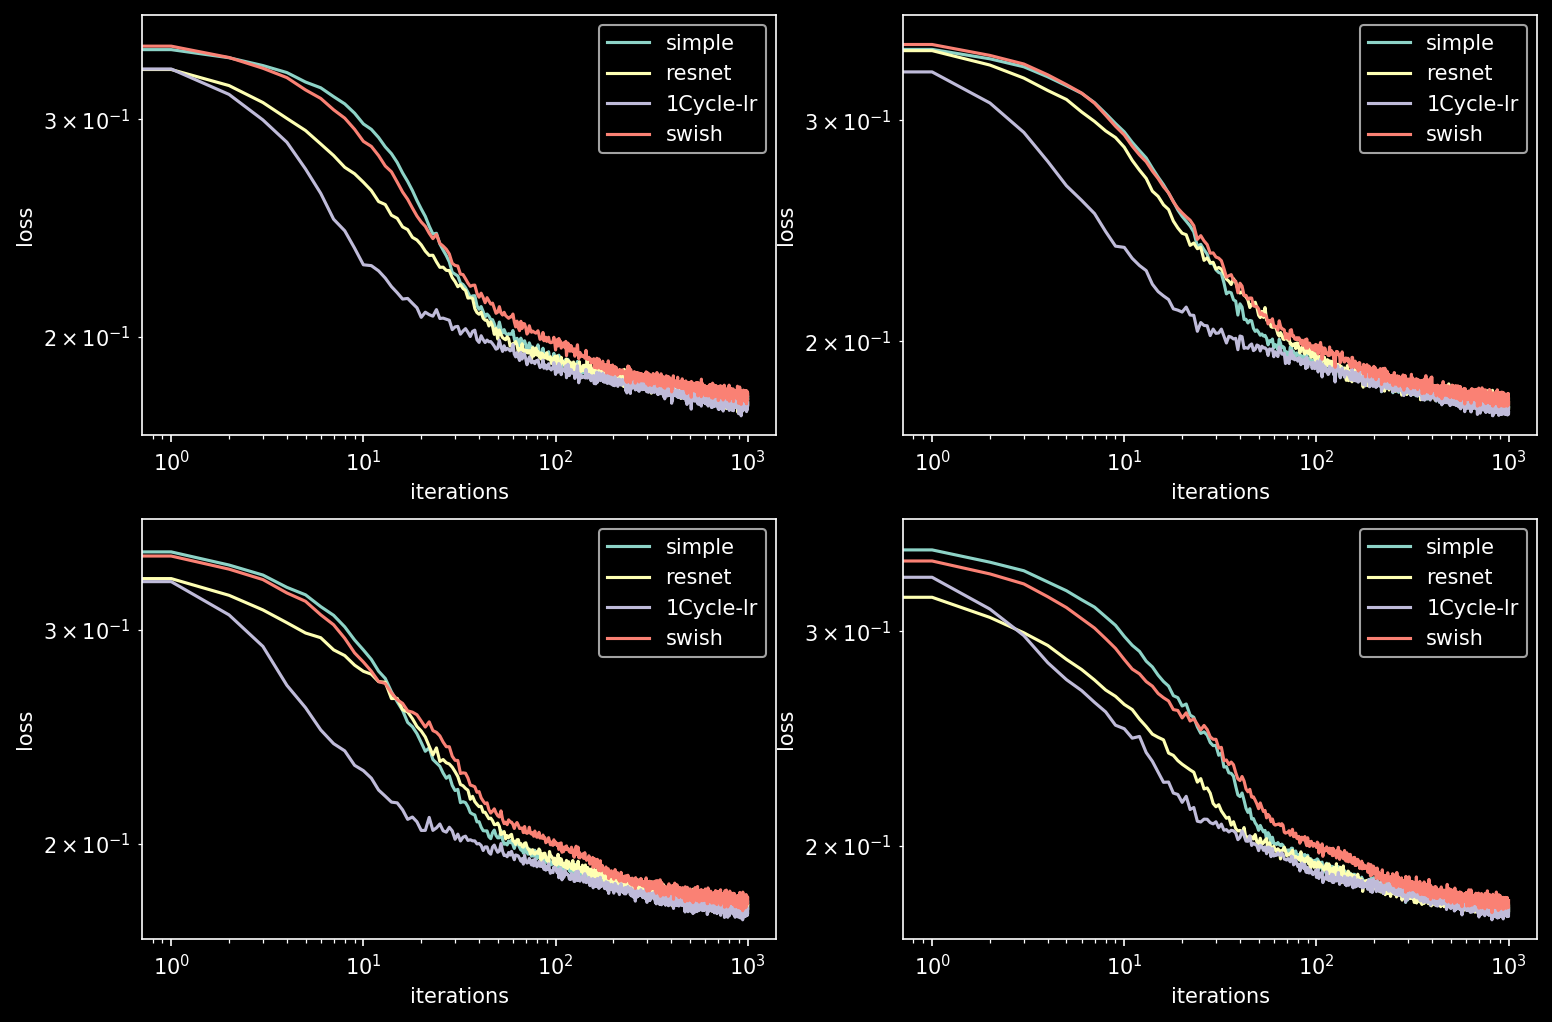

In [161]:
fig, axes= plt.subplots(2,2,figsize=(6*2,4*2),dpi=150)
for i,ax in enumerate(axes.flatten()):
    i += 4
    ax.plot(model_simple[i].losses,label='simple')
    ax.plot(model_dense[i].losses,label='resnet')
    ax.plot(model_lr[i].losses,label='1Cycle-lr')
    ax.plot(model_swish[i].losses,label='swish')
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("iterations")
    ax.set_ylabel("loss")
    ax.legend()

Text(0, 0.5, 'R50')

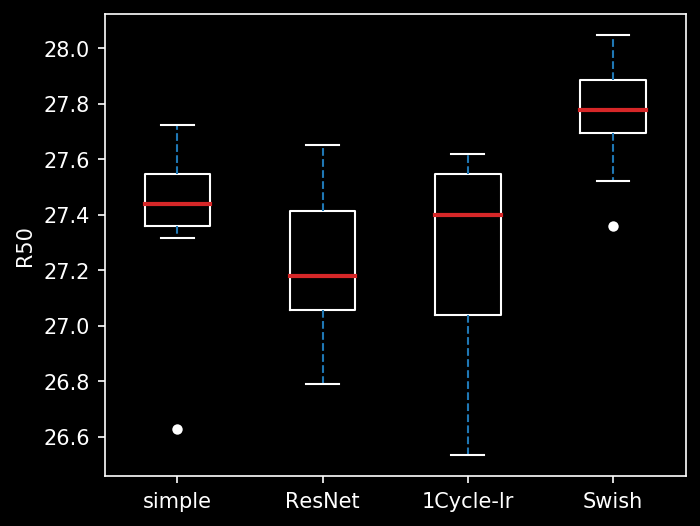

In [159]:
fig, ax= plt.subplots(1,1,figsize=(5,4),dpi=150)
bplot = ax.boxplot([[x[1] for x in jsdR50_simple],[x[1] for x in jsdR50_dense],[x[1] for x in jsdR50_lr],[x[1] for x in jsdR50_swish]],
                   labels=['simple',"ResNet","1Cycle-lr","Swish"],
                  #meanline=False,showmeans=True
                  )

for patch in bplot['boxes']:
    patch.set_color('white')
    patch.set_linewidth(1)
for patch in bplot['whiskers']:
    patch.set_color('tab:blue')
    patch.set_linewidth(1)
    patch.set_linestyle('--')
for patch in bplot['fliers']:
    patch.set_color('white')
for patch in bplot['caps']:
    patch.set_color('white')
for patch in bplot['fliers']:
    patch.set_color('white')
    patch.set_markerfacecolor("white")
    patch.set_linestyle('--')
for patch in bplot['medians']:
    patch.set_color('tab:red')
    patch.set_linewidth(2)
for patch in bplot['means']:
    patch.set_color('tab:orange')
    patch.set_linewidth(1)
    patch.set_marker("x")
ax.set_ylabel("R50")



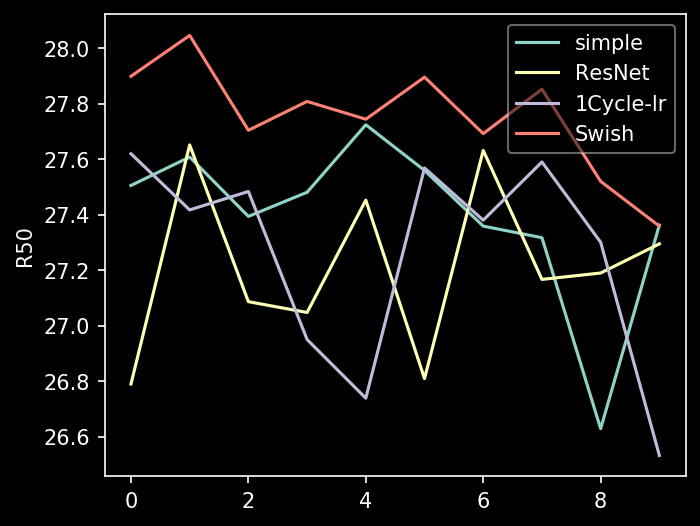

In [132]:
fig, ax= plt.subplots(1,1,figsize=(5,4),dpi=150)
plt.plot([x[1] for x in jsdR50_simple],label='simple')
plt.plot([x[1] for x in jsdR50_dense],label='ResNet')
plt.plot([x[1] for x in jsdR50_lr],label='1Cycle-lr')
plt.plot([x[1] for x in jsdR50_swish],label='Swish')
plt.ylabel("R50")
plt.legend(framealpha=0.5)

In [14]:
# with open(path+"jsdR50_simple.txt",'w') as f:
#     f.writelines([str(x)+"\n" for x in jsdR50_simple])    
# with open(path+"losses_simple.txt",'w') as f:
#     f.writelines([str(x.losses) + "\n" for x in model_simple])

# with open(path+"jsdR50_dense.txt",'w') as f:
#     f.writelines([str(x)+"\n" for x in jsdR50_dense])
# with open(path+"losses_dense.txt",'w') as f:
#     f.writelines([str(x.losses) + "\n" for x in model_dense])
    
# with open(path+"jsdR50_lr.txt",'w') as f:
#     f.writelines([str(x)+"\n" for x in jsdR50_lr])    
# with open(path+"losses_lr.txt",'w') as f:
#     f.writelines([str(x.losses) + "\n" for x in model_lr])

# with open(path+"jsdR50_swish.txt",'w') as f:
#     f.writelines([str(x)+"\n" for x in jsdR50_swish])
# with open(path+"losses_swish.txt",'w') as f:
#     f.writelines([str(x.losses) + "\n" for x in model_swish])

In [44]:
from torchsummary import summary

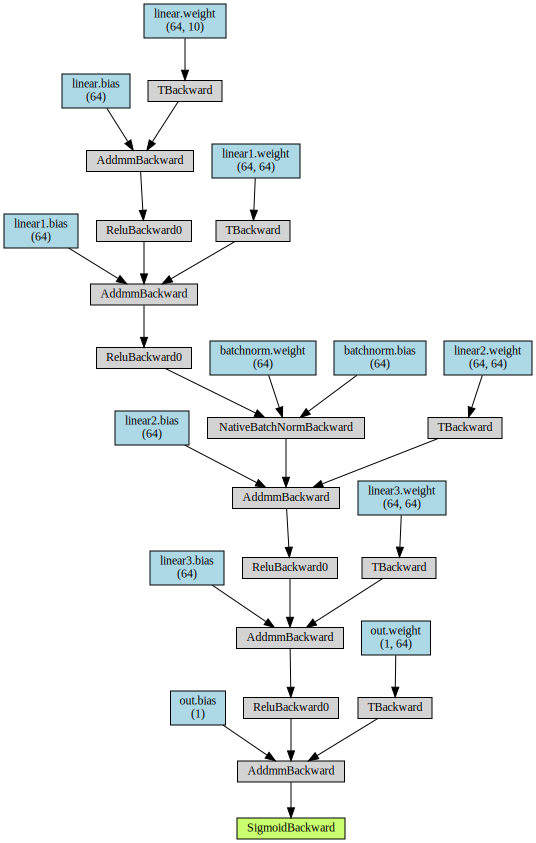

In [58]:
from torchviz import make_dot
model_L = Model()
model_L
x = torch.rand((2,10))
make_dot(model_L(x),dict(model_L.named_parameters()))

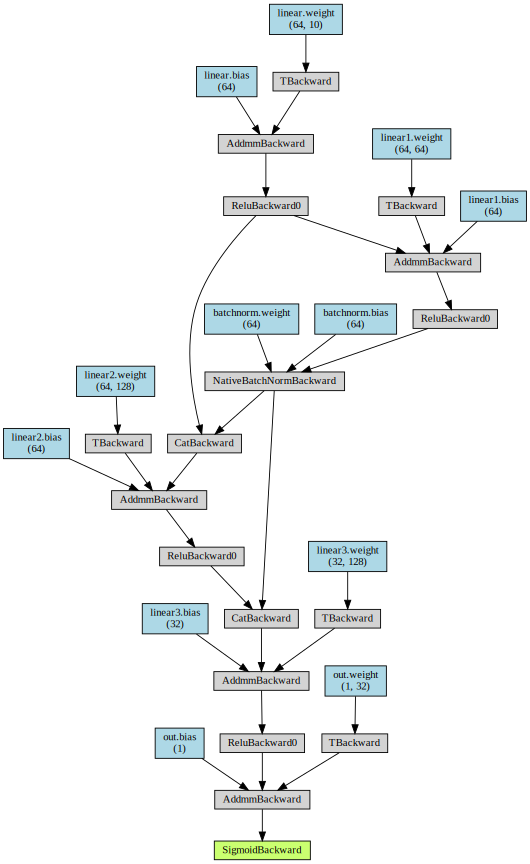

In [59]:
model_L = Model2()
model_L
x = torch.rand((2,10))
make_dot(model_L(x),dict(model_L.named_parameters()))